# Importing Libs

Here most of the libs are imported, this helps to ensure that all the packages are corrected installed.

_gametoy_ is our file containing **FooEnv** which is the simulator itself.

In [1]:
from gametoy import FooEnv 

In [2]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import time
import os
import matplotlib.pyplot as plt

C:\Users\RASSB\Anaconda3\envs\tensorflowgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialize RL Parameters

These here are the key parameters when working with this RL technique. It will define: the learning rate, how fast does it changes? Memory size, how much time steps will be in our memory? The exploration decay, how long we will priorize random solutions over the ones learned? Check the pdf of the work for more information about these parameters.

In [3]:
#ENV_NAME = ""

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 10000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.9999

Here we will initializate our simulator. The first number is the reward used, the second how we are changing the main parameters of the aircraft and the third in this case is the velocity, check the function code for more information.

In [ ]:
env = FooEnv(6,5,100)

# Functions

## Neural Network Function

The next class defines really important functions.
- **init**: defines the neural network that will be used, here it is recommended for the user to personalizate it by himself/herself. Try new possibilities, simpler or even far more complexes networks.
- rembember: saves the the step and all relevant information for the technique called **Replay Memory**.
- **act** : exploration x explotation, it in this point that the code decides, during training, if it should take a random action or the best learned action.
- play : same as act, but ensures that the Neural Network will not take random actions, only the best one learned.
- **experience replay**: applies the **Replay memory** memory to our neural network, it's this function that trains the neural network

In [4]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(9, input_shape=(observation_space,), activation="relu"))
        for i in range(14):
            self.model.add(Dense(18, activation="relu"))
        self.model.add(Dense(9, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def play(self, state):
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])
    
    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, verbose=0)
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

## Score Function

In [5]:
class scorelog:

    def __init__(self, number_runs, logfile_path):
        self.n = number_runs
        self.i = 0
        self.mean_scores = np.zeros(self.n)
        self.mean_score = 0
        self.action_space = action_space
        self.scores = np.zeros(self.n)
        self.run = 0
        self.score = 0
        self.duration = 0
        self.logfile_path = logfile_path
        if not os.path.exists(logfile_path):
            self.logFile = open(logfile_path, 'w')
            self.logFile.write("Step,Mean_Reward,score,Time \n")
            #self.logFile.write("Step,Episode,Mean_Reward,score,Time \n")
        else:
            self.logFile = open(logfile_path,'a')
            
    def log(self, score, run,duration):
        self.i += 1
        self.run = run
        self.score = score
        self.duration = duration
        self.mean_score = (1.0/self.i)*(score- self.mean_score)
        self.mean_scores[self.i] = self.mean_score
        self.scores[self.i] = score
        
    def logwrite(self):
        self.logFile.write("%d,%.3f,%.3f,%.3f \n" % (self.run, self.mean_score, self.score, self.duration))
        
    def logclose(self):
        self.logFile.close()
        self.logFile = open(self.logfile_path,'a')
        
    def scoreplot(self):
        plt.plot(self.mean_scores[:self.i])
        plt.show()
        plt.plot(self.scores[:self.i])
        plt.show()

## Play and tests functions

These functions were created to make it easier to play a single game and see its results or plot it into a file.

In [6]:
def play_one(Filename):
    #The agent will play one game and plot the results in the specified file.
        step = 0
        state = env.reset()
        env.zrefer()
        beta = env.beta
        state = np.reshape(np.append(beta,state), [1, observation_space])
        while True:
            step += 1
            action = dqn_solver.play(state)
            state_next, reward, terminal, info = env.step(action)
            reward = reward# if not terminal else -reward
            state_next = np.reshape(np.append(env.beta,state_next), [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal)
            state = state_next
            if step>10000:
                break
        env.plot(Filename)
        print('Score:',env.score)        

def play_render():
        #The agent will play one game and plot the results inside the jupyter notebook.
        step = 0
        state = env.reset()
        env.zrefer()
        beta = env.beta
        state = np.reshape(np.append(beta,state), [1, observation_space])
        while True:
            step += 1
            action = dqn_solver.play(state)
            state_next, reward, terminal, info = env.step(action)
            reward = reward# if not terminal else -reward
            state_next = np.reshape(np.append(env.beta,state_next), [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal)
            state = state_next
            if step>10000:
                break
        env.render()
        print('Score:',env.score)

def play_dumb():
    #The game will be played with only "0s" actions.
    step = 0
    state = env.reset()
    env.zrefer()
    beta = env.beta
    state = np.reshape(np.append(beta,state), [1, observation_space])
    while True:
        step += 1
        action = 0
        state_next, reward, terminal, info = env.step(action)
        reward = reward# if not terminal else -reward
        state_next = np.reshape(np.append(env.beta,state_next), [1, observation_space])
        dqn_solver.remember(state, action, reward, state_next, terminal)
        state = state_next
        if step>10000:
            break
    env.render()
    print('Score:',env.score)
        
def play_vel(Filename):
        #The agent will play one game and plot the results in the specified file, containing the velocity on its name.
        step = 0
        state = env.reset()
        env.zrefer()
        beta = env.beta
        state = np.reshape(np.append(beta,state), [1, observation_space])
        while True:
            step += 1
            action = dqn_solver.play(state)
            state_next, reward, terminal, info = env.step(action)
            reward = reward# if not terminal else -reward
            state_next = np.reshape(np.append(env.beta,state_next), [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal)
            state = state_next
            if step>10000:
                break
        env.plot(Filename+str(env.V))
        print('Score:',env.score)

# Preparing files

In [8]:
observation_space = env.observation_space+1 #defines the observation space
action_space  = env.action_space # receives the action space

In [9]:
run = 0 #initialize the counting to 0

In [10]:
dqn_solver = DQNSolver(observation_space, action_space) #generates the neural network
dqn_solver.model.summary() #plots the neural network's structure generated

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 54        
_________________________________________________________________
dense_2 (Dense)              (None, 18)                180       
_________________________________________________________________
dense_3 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_4 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_5 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_6 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_7 (Dense)              (None, 36)                684       
__________

Initializes some values and states where the files will be saved.

In [11]:
DQN_SAVE = "dqn_PCC_toy_R6-Flutter-1_"
filepath = 'NN/'+ DQN_SAVE
if not os.path.exists(filepath):
    os.makedirs(filepath)
DQN_SAVE_FILE = filepath + '/' + DQN_SAVE + '0.h5'
counter_dqn = 0
dqn_solver.model.save(DQN_SAVE_FILE)

logfile = filepath+'/log.txt'
scoreLog = scorelog(100000,logfile)

duration = 0
counter_play = 0

filename_play = filepath + '/' + 'Gameplay/' 
if not os.path.exists(filename_play):
    os.makedirs(filename_play)

# Training

Here we have the code responsible for training our Neural Network and keeping the log, it is important to state that it is an infinite loop which is broken by an _if_ condition, if you erases it, it will keep running foreverrrrrr!!!! So, pay attention to this.


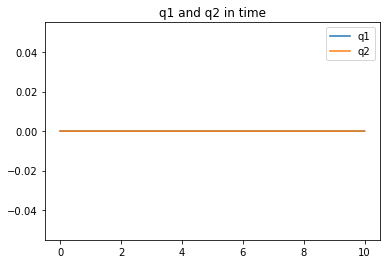

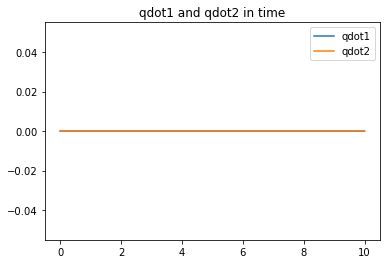

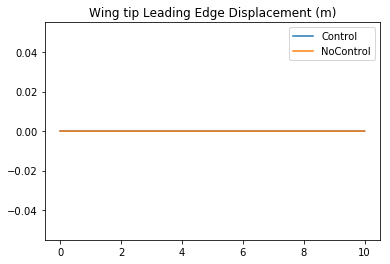

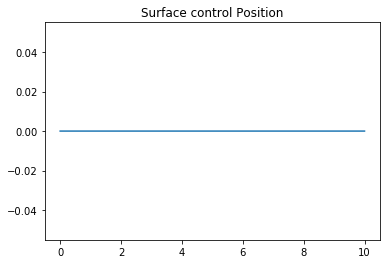

Run: 1, exploration: 0.9821601483548376, steps: 181, score: [363.28489834] , time:62.016130685806274
Run: 2, exploration: 0.9629999827221808, steps: 198, score: [342.25536297] , time:59.39314651489258
Run: 3, exploration: 0.9023027787625493, steps: 652, score: [493.52866123] , time:151.90375304222107
Run: 4, exploration: 0.8839045737558167, steps: 207, score: [356.51712585] , time:58.38284730911255
Run: 5, exploration: 0.8673548374849623, steps: 190, score: [271.68030503] , time:55.36089015007019


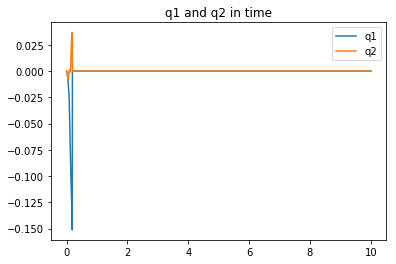

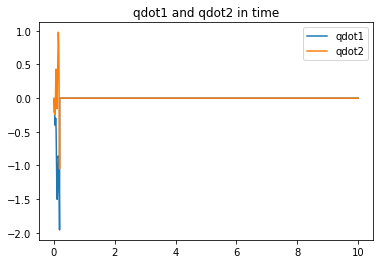

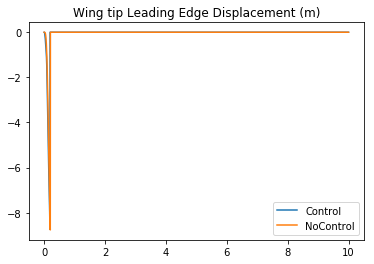

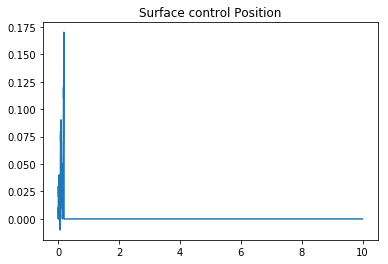

Run: 6, exploration: 0.8517109881081575, steps: 183, score: [280.8111743] , time:54.10429573059082
Run: 7, exploration: 0.8343443638058464, steps: 207, score: [374.97735863] , time:58.30107569694519
Run: 8, exploration: 0.8180678164098123, steps: 198, score: [342.34392486] , time:55.457661867141724
Run: 9, exploration: 0.8029916442695944, steps: 187, score: [251.39715083] , time:53.09399628639221
Run: 10, exploration: 0.7857535732068461, steps: 218, score: [464.44395368] , time:59.9227294921875


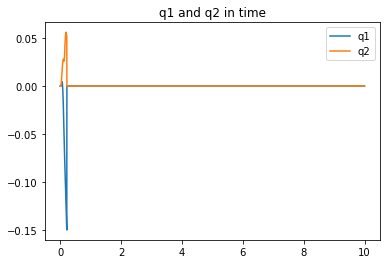

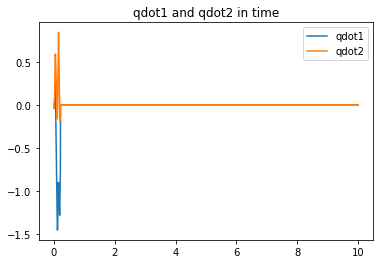

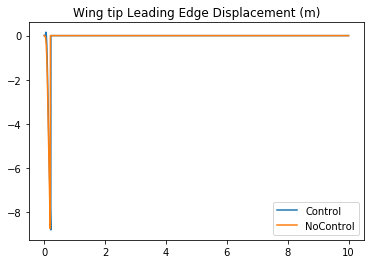

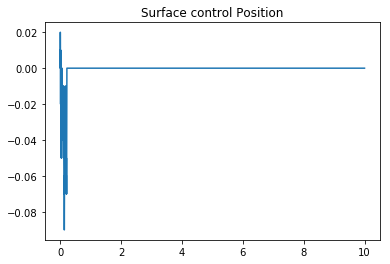

Run: 11, exploration: 0.7711957929764771, steps: 188, score: [231.89520997] , time:54.255884885787964
Run: 12, exploration: 0.7584231331603222, steps: 168, score: [334.42188057] , time:49.04881548881531
Run: 13, exploration: 0.7473553075338344, steps: 148, score: [221.46560595] , time:44.90688991546631
Run: 14, exploration: 0.7327024814975474, steps: 199, score: [359.51450478] , time:56.50088381767273
Run: 15, exploration: 0.6676974038351606, steps: 930, score: [1129.64416485] , time:203.4000163078308


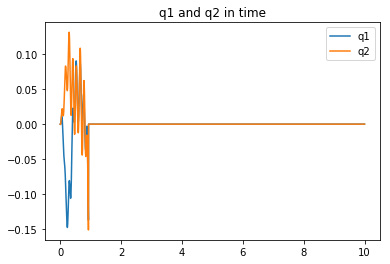

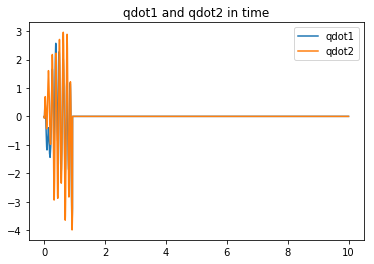

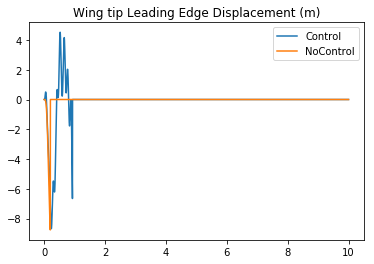

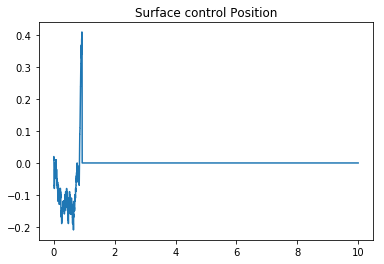

Run: 16, exploration: 0.6532330700449765, steps: 220, score: [505.61069756] , time:60.76444101333618
Run: 17, exploration: 0.6411946375163614, steps: 187, score: [490.82597535] , time:54.001566886901855
Run: 18, exploration: 0.629063435166869, steps: 192, score: [410.01050783] , time:54.706719160079956
Run: 19, exploration: 0.600720517515557, steps: 462, score: [525.13691184] , time:109.7963011264801
Run: 20, exploration: 0.5874720569266068, steps: 224, score: [322.36122076] , time:61.162413120269775


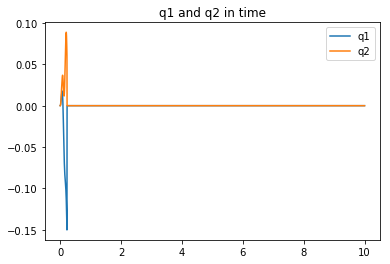

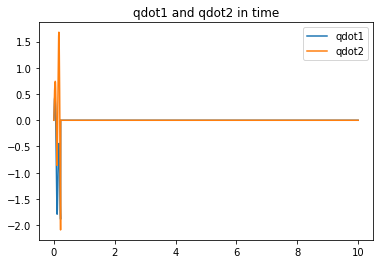

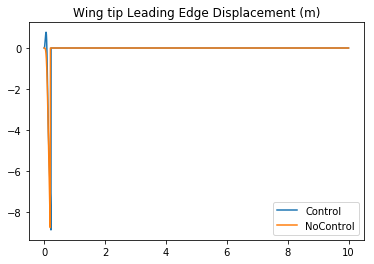

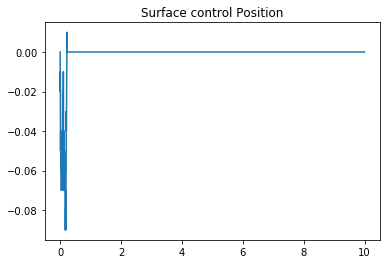

Run: 21, exploration: 0.5730812144158116, steps: 249, score: [446.15992216] , time:62.146390438079834
Run: 22, exploration: 0.5012579038020171, steps: 1340, score: [1237.0374671] , time:258.9528079032898
Run: 23, exploration: 0.49206942862027325, steps: 186, score: [425.90924925] , time:47.90244936943054
Run: 24, exploration: 0.4828079094545109, steps: 191, score: [356.75082264] , time:48.37260866165161
Run: 25, exploration: 0.4728214468804505, steps: 210, score: [481.58142684] , time:53.23818898200989


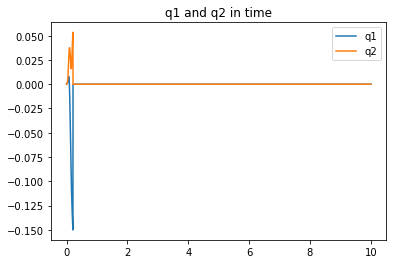

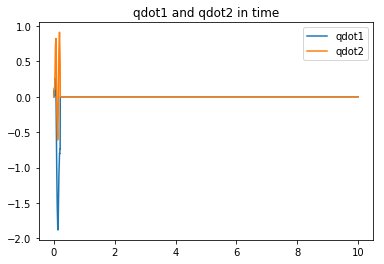

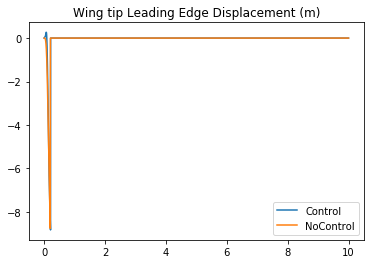

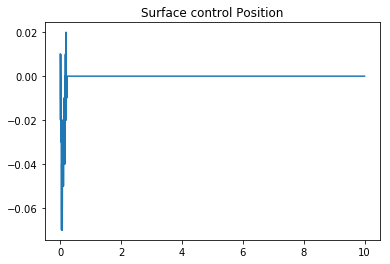

Run: 26, exploration: 0.4642935097808335, steps: 183, score: [272.37550294] , time:47.71244740486145
Run: 27, exploration: 0.4557370444895313, steps: 187, score: [273.20156995] , time:47.88110589981079
Run: 28, exploration: 0.4454187457051264, steps: 230, score: [455.72648735] , time:56.94523644447327
Run: 29, exploration: 0.4354211424097237, steps: 228, score: [352.56930792] , time:55.7329375743866
Run: 30, exploration: 0.4233131854034162, steps: 283, score: [423.58567477] , time:66.28881430625916


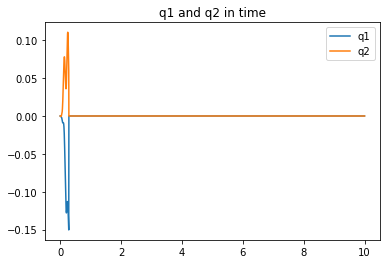

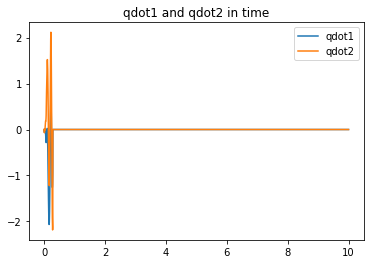

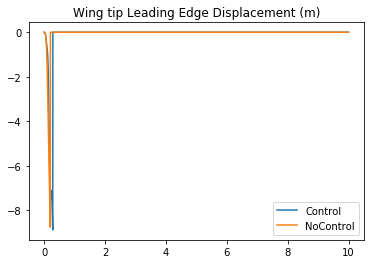

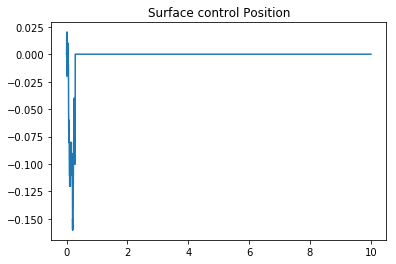

Run: 31, exploration: 0.41542884829349325, steps: 189, score: [290.53673398] , time:50.311436891555786
Run: 32, exploration: 0.38207127339659147, steps: 838, score: [975.32000194] , time:166.38599038124084
Run: 33, exploration: 0.37174413210021967, steps: 275, score: [415.64969325] , time:63.99569654464722
Run: 34, exploration: 0.3687450174846322, steps: 82, score: [242.22368132] , time:29.121115922927856
Run: 35, exploration: 0.3619132204573834, steps: 188, score: [403.71112642] , time:49.08220362663269


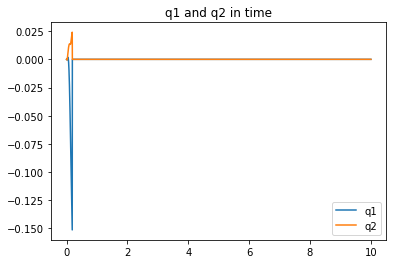

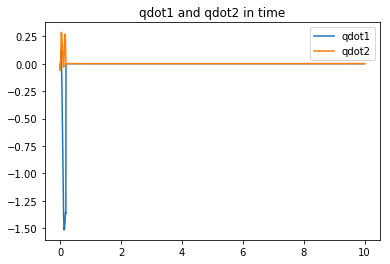

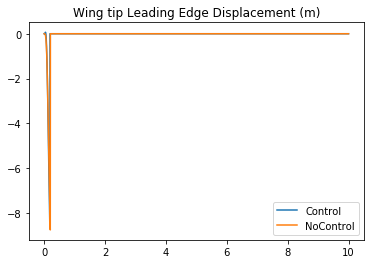

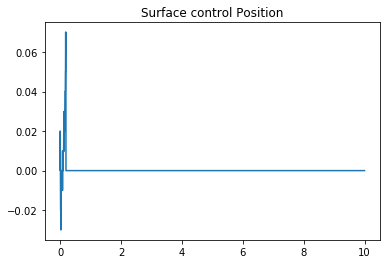

Run: 36, exploration: 0.3553501159366586, steps: 184, score: [278.67671993] , time:48.184972286224365
Run: 37, exploration: 0.3465760570642157, steps: 251, score: [467.64258734] , time:60.194435358047485
Run: 38, exploration: 0.3383906848689942, steps: 240, score: [439.44207544] , time:58.350252628326416
Run: 39, exploration: 0.3316565996790388, steps: 202, score: [395.16791889] , time:53.864930629730225
Run: 40, exploration: 0.3253817603621737, steps: 192, score: [304.02105016] , time:53.40915083885193


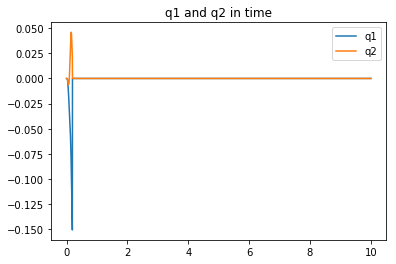

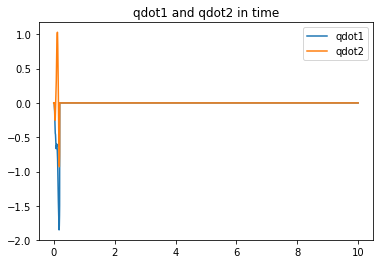

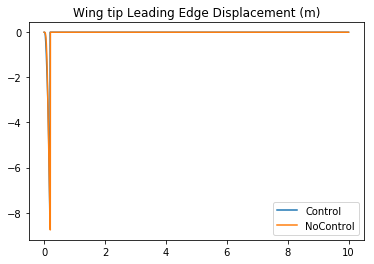

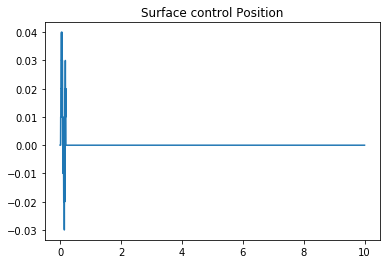

Run: 41, exploration: 0.31890655702025866, steps: 202, score: [440.75163874] , time:56.77913308143616
Run: 42, exploration: 0.3128416572352555, steps: 193, score: [376.87545348] , time:52.4037811756134
Run: 43, exploration: 0.30581980013231014, steps: 228, score: [291.81825783] , time:58.65807747840881
Run: 44, exploration: 0.3000337849961629, steps: 192, score: [407.21636825] , time:51.905173778533936
Run: 45, exploration: 0.2582395350102955, steps: 1501, score: [1091.88793183] , time:302.17178654670715


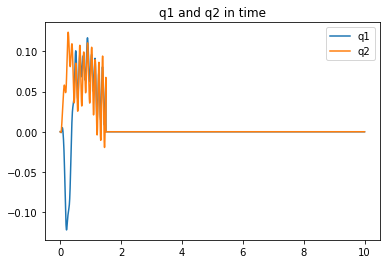

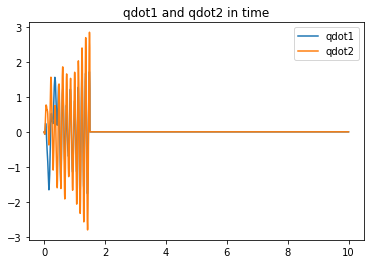

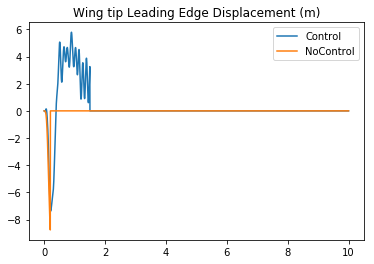

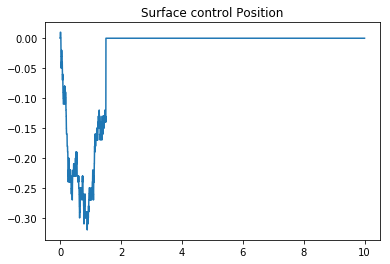

Run: 46, exploration: 0.2534550904647498, steps: 188, score: [278.14603272] , time:51.62594032287598
Run: 47, exploration: 0.24828707056707655, steps: 207, score: [448.54404145] , time:54.780444860458374
Run: 48, exploration: 0.21370105920948412, steps: 1501, score: [1002.56585796] , time:299.66551327705383
Run: 49, exploration: 0.20932270071958226, steps: 208, score: [403.12212067] , time:55.037832736968994
Run: 50, exploration: 0.20573238426516482, steps: 174, score: [393.21518737] , time:48.3007698059082


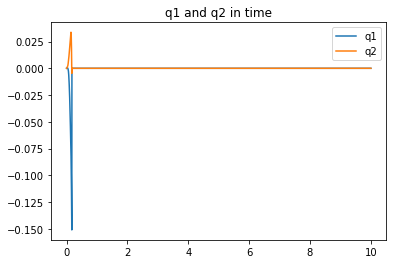

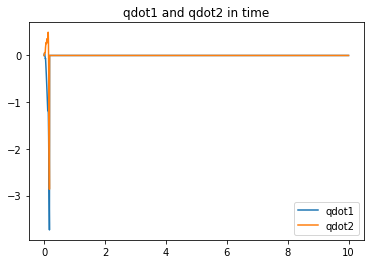

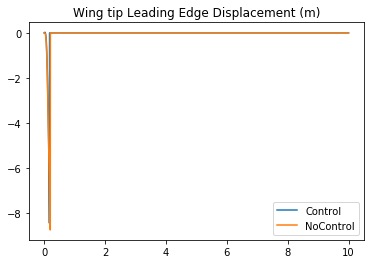

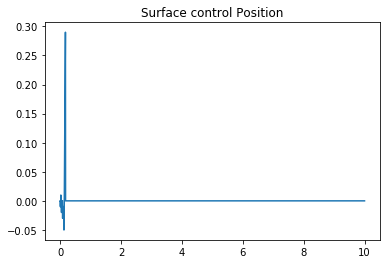

Run: 51, exploration: 0.2019409420671192, steps: 187, score: [334.86929649] , time:51.06242847442627
Run: 52, exploration: 0.19808066041745118, steps: 194, score: [317.13697284] , time:51.663819551467896
Run: 53, exploration: 0.1939059520972583, steps: 214, score: [380.43796429] , time:55.586289167404175
Run: 54, exploration: 0.19067538333491715, steps: 169, score: [399.97454282] , time:47.58174157142639
Run: 55, exploration: 0.187067864614451, steps: 192, score: [318.09128031] , time:52.19739127159119


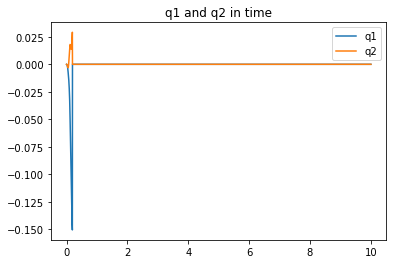

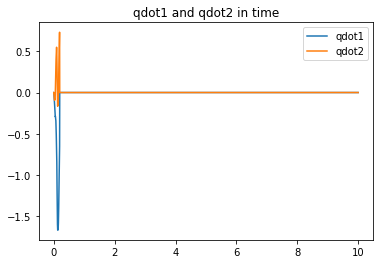

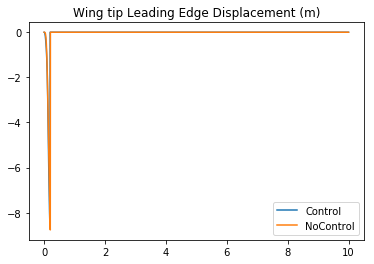

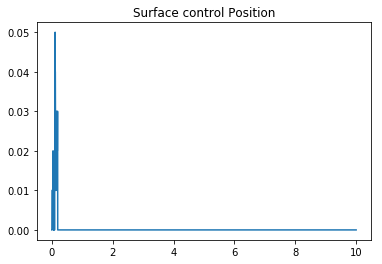

Run: 56, exploration: 0.18319852819265905, steps: 210, score: [378.33858351] , time:55.33500027656555
Run: 57, exploration: 0.17942716835335779, steps: 209, score: [408.32891309] , time:55.01201677322388
Run: 58, exploration: 0.17571587310230227, steps: 210, score: [441.1008099] , time:55.0308141708374
Run: 59, exploration: 0.17254661349466924, steps: 183, score: [339.0137902] , time:50.818082094192505
Run: 60, exploration: 0.16904524450493846, steps: 206, score: [374.3008991] , time:51.253408432006836


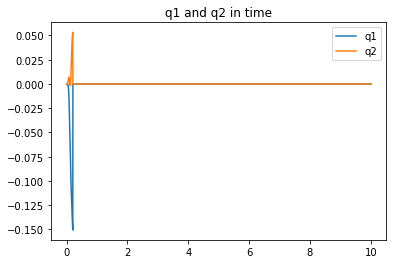

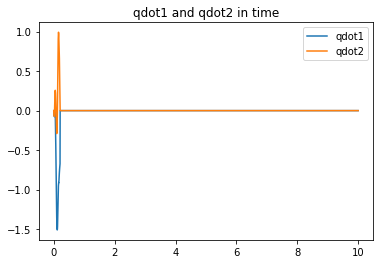

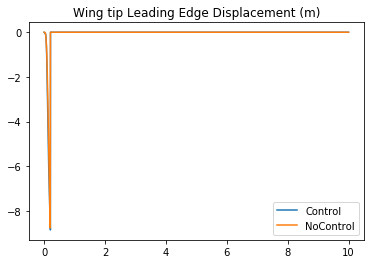

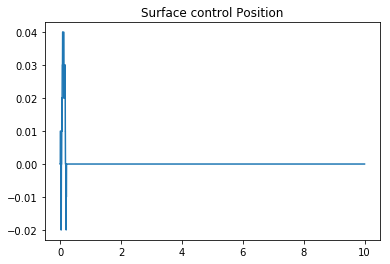

Run: 61, exploration: 0.1658303765616976, steps: 193, score: [388.14515434] , time:47.90030217170715
Run: 62, exploration: 0.14273045728641126, steps: 1501, score: [2401.08982402] , time:278.2765243053436
Run: 63, exploration: 0.13958263931937678, steps: 224, score: [351.78663846] , time:52.55156373977661
Run: 64, exploration: 0.13681858104973735, steps: 201, score: [376.58049644] , time:48.77208876609802
Run: 65, exploration: 0.13431058241900964, steps: 186, score: [385.4302552] , time:46.1055006980896


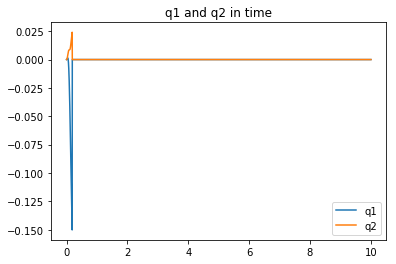

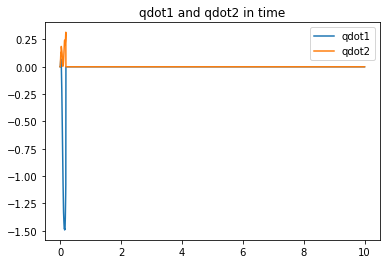

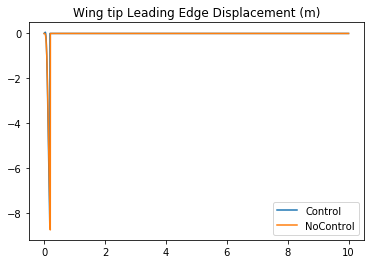

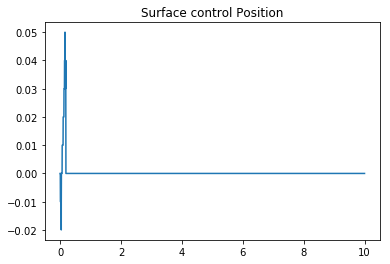

Run: 66, exploration: 0.13167725717306664, steps: 199, score: [336.32163468] , time:48.58400273323059
Run: 67, exploration: 0.12931522162461326, steps: 182, score: [322.99447641] , time:45.626805782318115
Run: 68, exploration: 0.1266531138104474, steps: 209, score: [301.23607424] , time:50.66894197463989
Run: 69, exploration: 0.10901052765919142, steps: 1501, score: [2694.29694567] , time:276.97503662109375
Run: 70, exploration: 0.10684118254219109, steps: 202, score: [350.1491502] , time:49.524840116500854


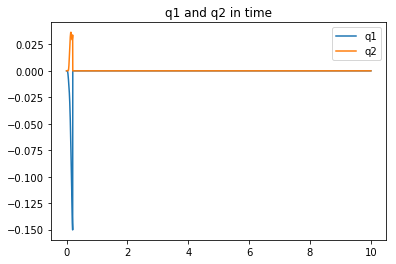

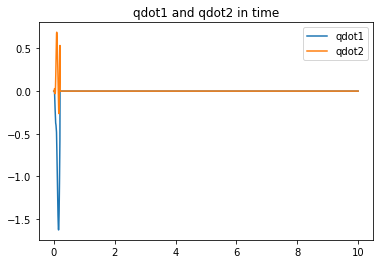

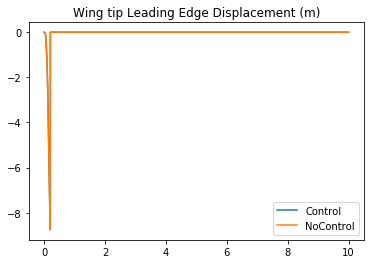

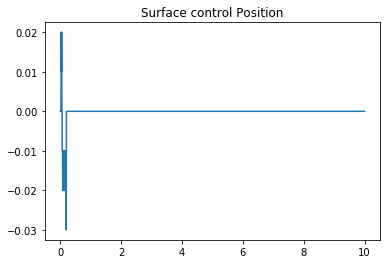

Run: 71, exploration: 0.10483026375257683, steps: 191, score: [388.37730115] , time:47.471309423446655
Run: 72, exploration: 0.10275438269138835, steps: 201, score: [316.22760364] , time:48.7601273059845
Run: 73, exploration: 0.10078006178625741, steps: 195, score: [436.51598983] , time:47.8216335773468
Run: 74, exploration: 0.09888322280486145, steps: 191, score: [353.8345928] , time:47.2061402797699
Run: 75, exploration: 0.09697358396960025, steps: 196, score: [334.85924684] , time:47.955936670303345


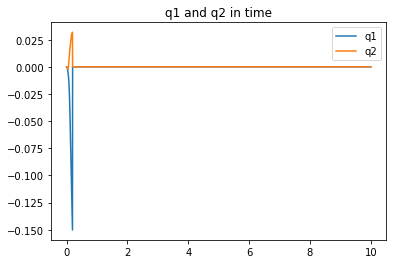

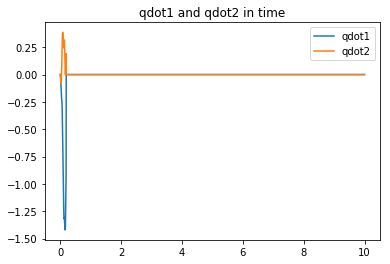

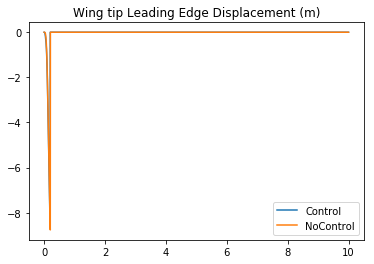

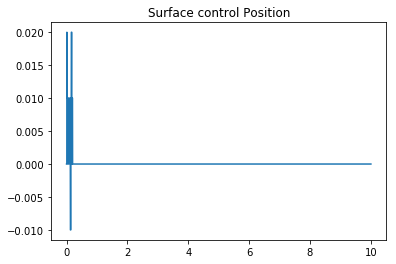

Run: 76, exploration: 0.09501526768263502, steps: 205, score: [370.62283915] , time:50.40764880180359
Run: 77, exploration: 0.0817797853850234, steps: 1501, score: [2567.04603332] , time:277.6219599246979
Run: 78, exploration: 0.07980042781684796, steps: 246, score: [452.7516463] , time:57.55097436904907
Run: 79, exploration: 0.07828279957479577, steps: 193, score: [374.47964993] , time:47.557525396347046
Run: 80, exploration: 0.07683244181520352, steps: 188, score: [368.08863156] , time:46.31841778755188


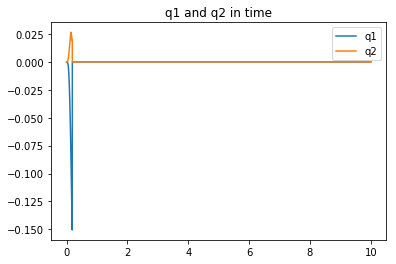

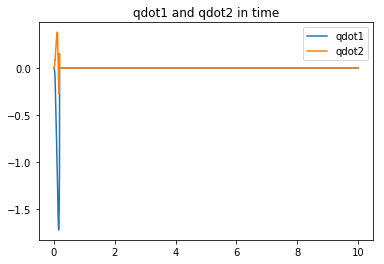

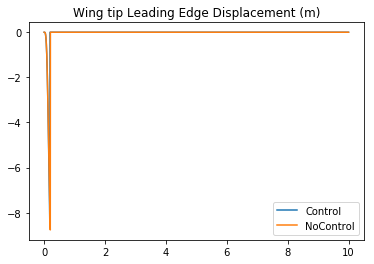

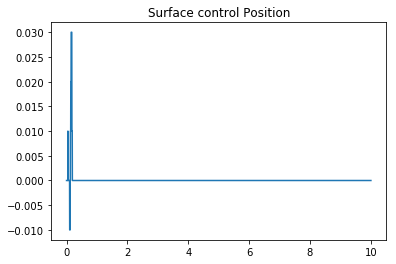

Run: 81, exploration: 0.07504033660406574, steps: 237, score: [441.34916693] , time:55.38768744468689
Run: 82, exploration: 0.07351759499678091, steps: 206, score: [343.5016435] , time:49.72810173034668
Run: 83, exploration: 0.07206898391232179, steps: 200, score: [370.45614896] , time:48.42847204208374
Run: 84, exploration: 0.0705712416994139, steps: 211, score: [430.88414514] , time:51.570685386657715
Run: 85, exploration: 0.06911844865909589, steps: 209, score: [415.69531508] , time:50.21217608451843


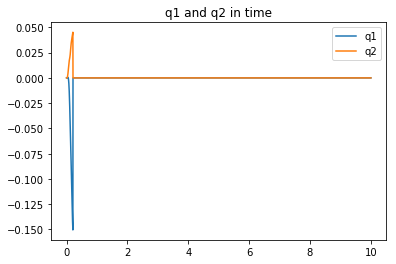

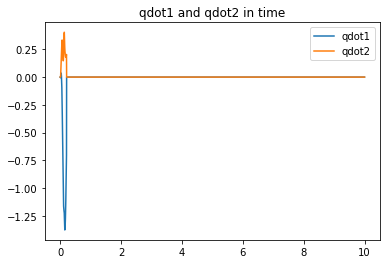

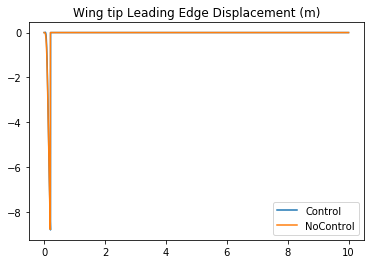

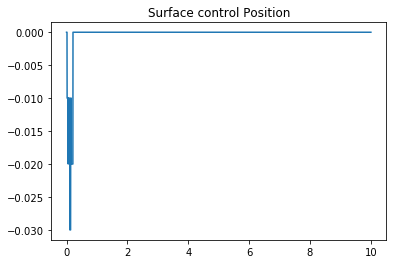

Run: 86, exploration: 0.06766172208070172, steps: 214, score: [377.64343363] , time:51.693177461624146
Run: 87, exploration: 0.06626219808363458, steps: 210, score: [342.65808802] , time:50.55999684333801
Run: 88, exploration: 0.06450986964487727, steps: 269, score: [366.88627968] , time:60.269795656204224
Run: 89, exploration: 0.06331468512774296, steps: 188, score: [334.29089647] , time:46.163697481155396
Run: 90, exploration: 0.06210436831604903, steps: 194, score: [411.03111432] , time:48.49685335159302


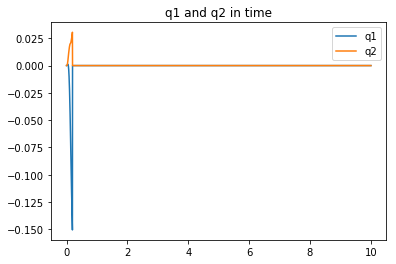

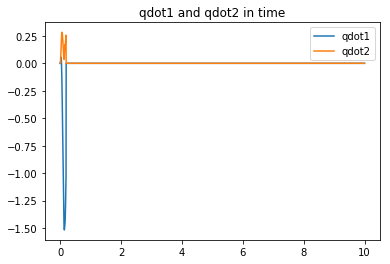

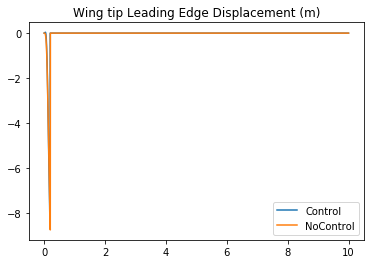

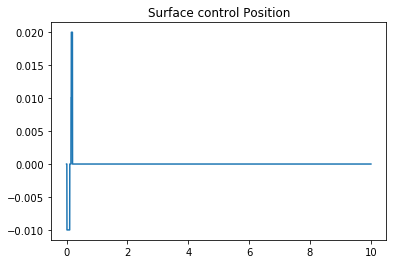

Run: 91, exploration: 0.06095984688566043, steps: 187, score: [393.48818449] , time:46.49397611618042
Run: 92, exploration: 0.05977063068173782, steps: 198, score: [373.50541997] , time:48.01537251472473
Run: 93, exploration: 0.05846412448882169, steps: 222, score: [433.6328803] , time:52.38844323158264
Run: 94, exploration: 0.05759366387423413, steps: 151, score: [380.0198185] , time:40.00400400161743
Run: 95, exploration: 0.05641367109309812, steps: 208, score: [397.83683966] , time:49.83676886558533


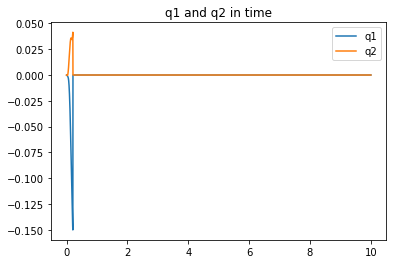

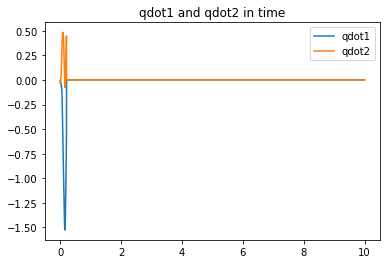

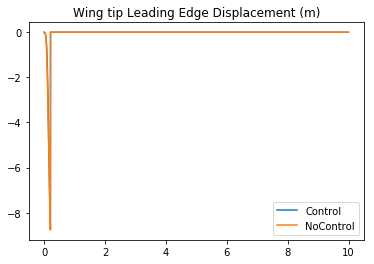

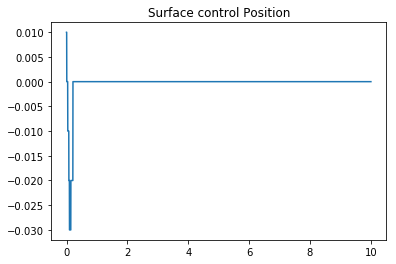

Run: 96, exploration: 0.055307611230723905, steps: 199, score: [391.600553] , time:49.2482807636261
Run: 97, exploration: 0.05425035679516724, steps: 194, score: [354.01907448] , time:47.59489297866821
Run: 98, exploration: 0.05317607457739463, steps: 201, score: [394.65633376] , time:48.39371132850647
Run: 99, exploration: 0.052081381764895775, steps: 209, score: [377.95519609] , time:50.93022394180298
Run: 100, exploration: 0.05105515577203137, steps: 200, score: [411.82747802] , time:48.95605421066284


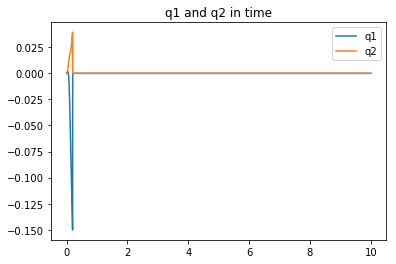

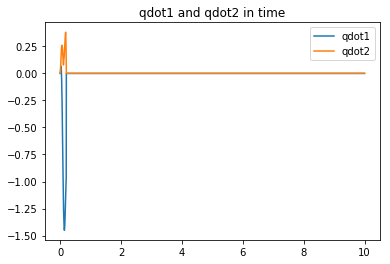

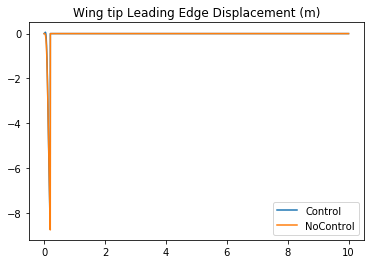

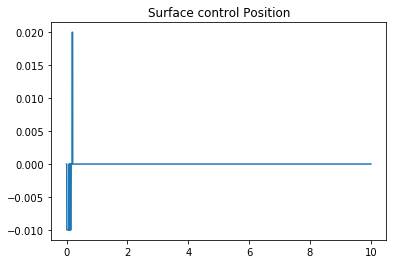

Run: 101, exploration: 0.04991918555834273, steps: 226, score: [394.80076433] , time:53.58320426940918
Run: 102, exploration: 0.04889642932724651, steps: 208, score: [435.68217328] , time:50.6560640335083
Run: 103, exploration: 0.047928167224617985, steps: 201, score: [373.2342345] , time:48.95411968231201
Run: 104, exploration: 0.04696029013233904, steps: 205, score: [376.29769741] , time:49.62230610847473
Run: 105, exploration: 0.046053390142551956, steps: 196, score: [375.24392821] , time:47.68756699562073


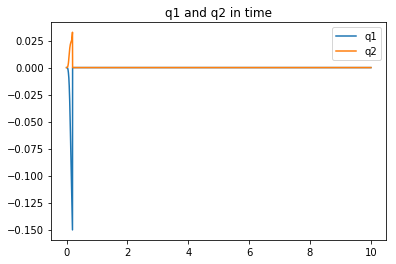

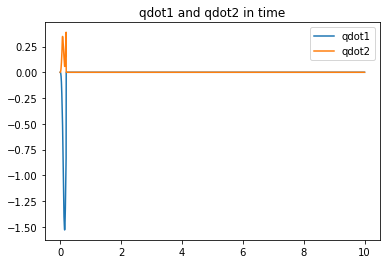

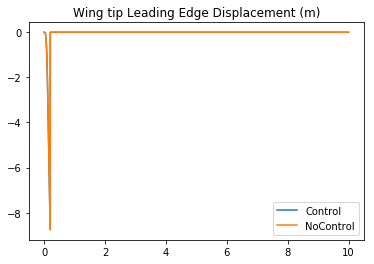

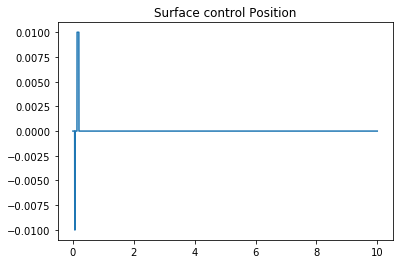

Run: 106, exploration: 0.04516400426073052, steps: 196, score: [342.96212215] , time:48.36139464378357
Run: 107, exploration: 0.04430951540111924, steps: 192, score: [322.57788335] , time:47.18852734565735
Run: 108, exploration: 0.043384333363268336, steps: 212, score: [374.44723412] , time:50.93427109718323
Run: 109, exploration: 0.042529476424536194, steps: 200, score: [373.34771368] , time:49.445865869522095
Run: 110, exploration: 0.041678957635603905, steps: 203, score: [390.57626901] , time:48.97658610343933


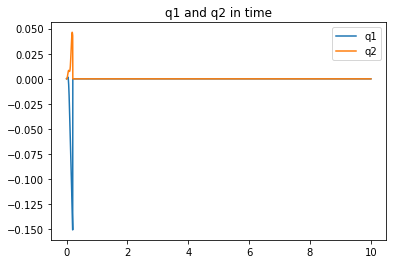

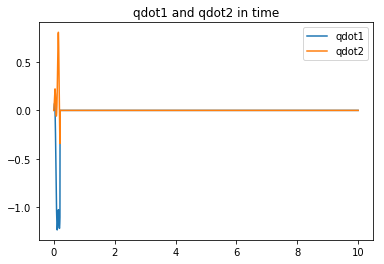

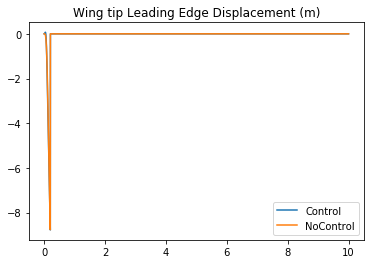

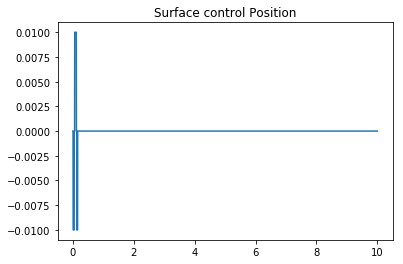

Run: 111, exploration: 0.04089858407787654, steps: 190, score: [344.34904848] , time:47.16985893249512
Run: 112, exploration: 0.04006865742145677, steps: 206, score: [378.03113539] , time:49.589184045791626
Run: 113, exploration: 0.03921241234720233, steps: 217, score: [374.93368273] , time:51.62267994880676
Run: 114, exploration: 0.03828247187765171, steps: 241, score: [437.1126715] , time:55.51249313354492
Run: 115, exploration: 0.0375168861155865, steps: 203, score: [373.32925585] , time:50.52112889289856


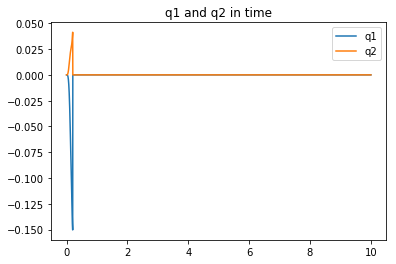

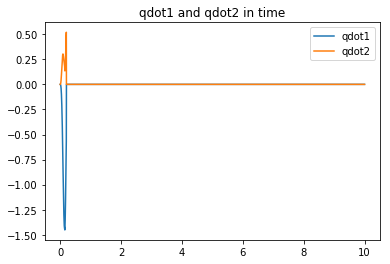

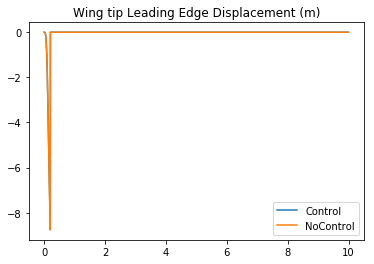

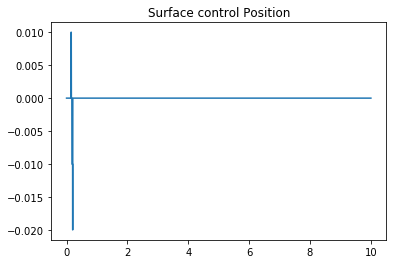

Run: 116, exploration: 0.03675925784086577, steps: 205, score: [340.21417743] , time:49.760276556015015
Run: 117, exploration: 0.03600612536110449, steps: 208, score: [413.56466188] , time:49.97539973258972
Run: 118, exploration: 0.03530371106862427, steps: 198, score: [369.59841355] , time:48.22808647155762
Run: 119, exploration: 0.03459077637501035, steps: 205, score: [374.94212643] , time:49.54635190963745
Run: 120, exploration: 0.033841436130947825, steps: 220, score: [375.35236697] , time:52.534329414367676


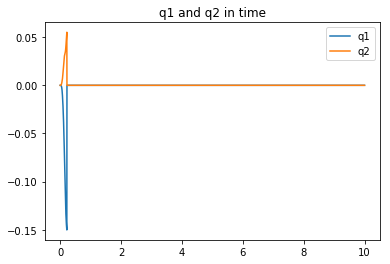

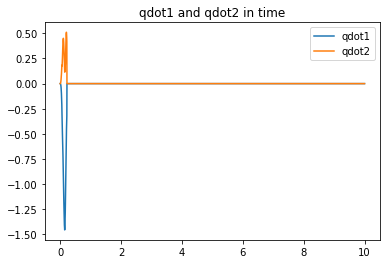

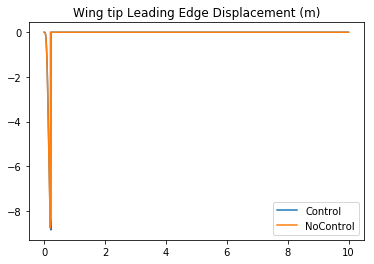

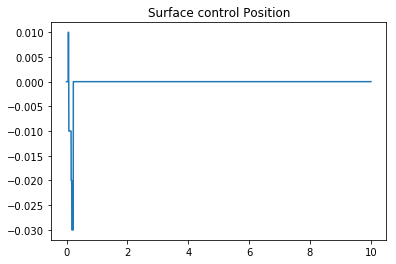

Run: 121, exploration: 0.03314145539584347, steps: 210, score: [434.89002875] , time:51.840001821517944
Run: 122, exploration: 0.03244946228865424, steps: 212, score: [385.09433424] , time:50.873159646987915
Run: 123, exploration: 0.0318227962920165, steps: 196, score: [336.28277357] , time:48.01483941078186
Run: 124, exploration: 0.0312425821694817, steps: 185, score: [299.13181212] , time:46.13574934005737
Run: 125, exploration: 0.030630032667472475, steps: 199, score: [368.55737825] , time:48.81577253341675


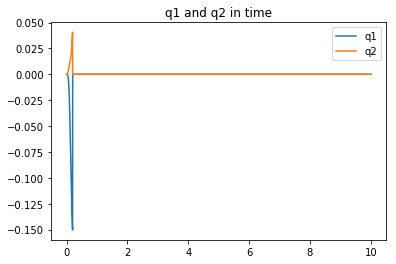

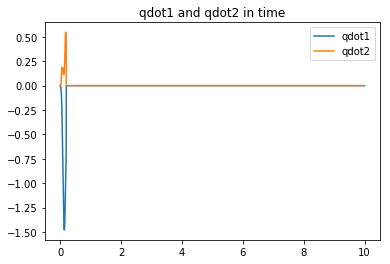

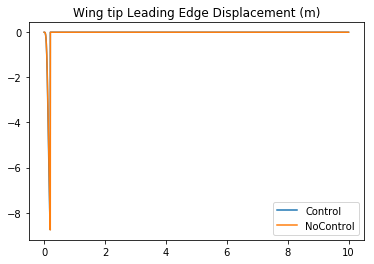

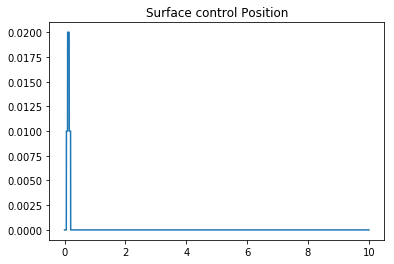

Run: 126, exploration: 0.029996477025806285, steps: 210, score: [433.02922675] , time:50.47103309631348
Run: 127, exploration: 0.02942895304590925, steps: 192, score: [350.0312622] , time:47.883065700531006
Run: 128, exploration: 0.028849076791956762, steps: 200, score: [364.47468455] , time:48.660762786865234
Run: 129, exploration: 0.028323081476423068, steps: 185, score: [306.86979938] , time:45.780442237854004
Run: 130, exploration: 0.027784438896094832, steps: 193, score: [344.52318018] , time:47.37673020362854


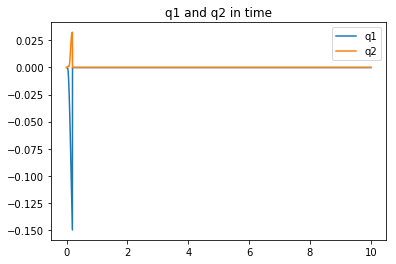

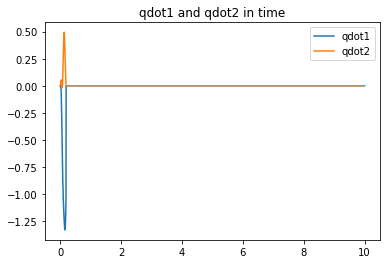

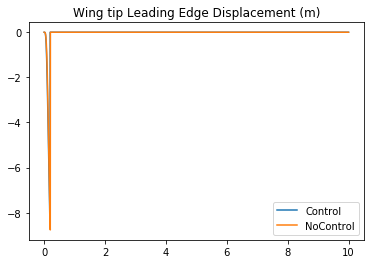

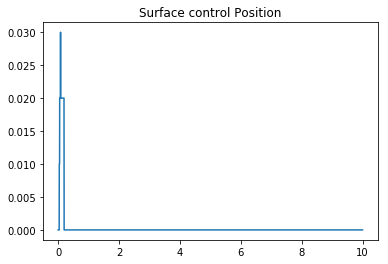

Run: 131, exploration: 0.027231519484161686, steps: 202, score: [406.6978967] , time:49.23047661781311
Run: 132, exploration: 0.02669761183182708, steps: 199, score: [372.83609821] , time:48.275755882263184
Run: 133, exploration: 0.026208222354139242, steps: 186, score: [320.08601143] , time:46.56113386154175
Run: 134, exploration: 0.025645602303740196, steps: 218, score: [413.97196254] , time:51.56437873840332
Run: 135, exploration: 0.025120169060729673, steps: 208, score: [373.2791285] , time:50.128732204437256


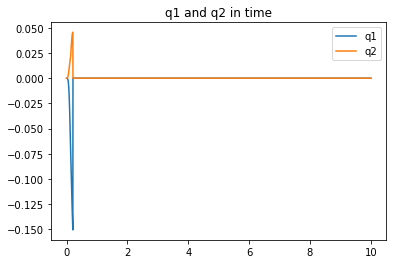

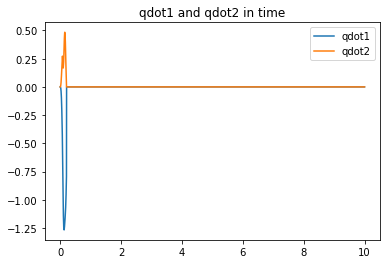

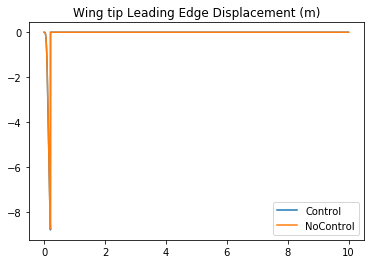

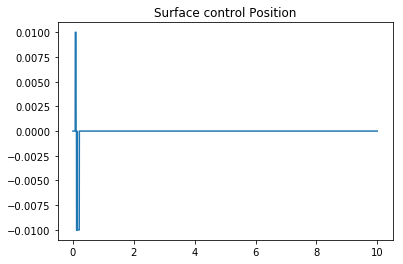

Run: 136, exploration: 0.024637510573393133, steps: 195, score: [342.82751674] , time:48.29674696922302
Run: 137, exploration: 0.024144801341659, steps: 203, score: [378.72869259] , time:49.03246331214905
Run: 138, exploration: 0.023631203395467336, steps: 216, score: [407.28326867] , time:51.45176076889038
Run: 139, exploration: 0.023160934726967036, steps: 202, score: [373.23936753] , time:49.43614459037781
Run: 140, exploration: 0.022693215232229388, steps: 205, score: [373.59887739] , time:50.42132329940796


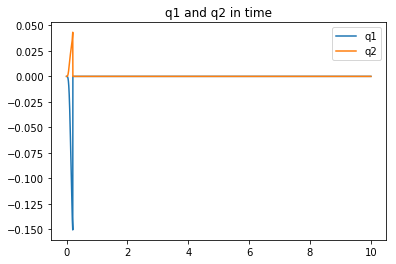

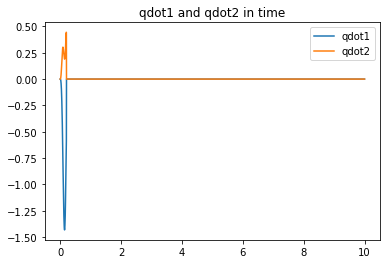

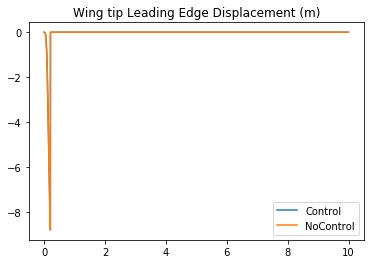

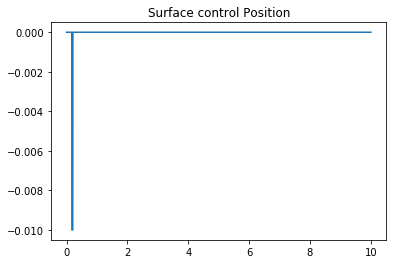

Run: 141, exploration: 0.022212716080056177, steps: 215, score: [376.41782066] , time:51.67504572868347
Run: 142, exploration: 0.021751090000008865, steps: 211, score: [381.74760281] , time:50.82001090049744
Run: 143, exploration: 0.02131610437874006, steps: 203, score: [392.75956565] , time:49.09360861778259
Run: 144, exploration: 0.02090862798621975, steps: 194, score: [336.92796468] , time:47.31257224082947
Run: 145, exploration: 0.020470008932012337, steps: 213, score: [386.87670763] , time:51.25417351722717


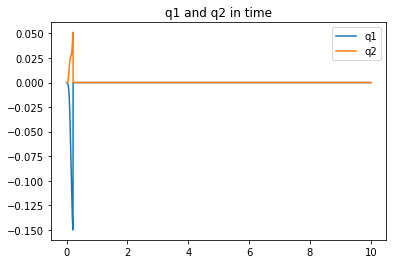

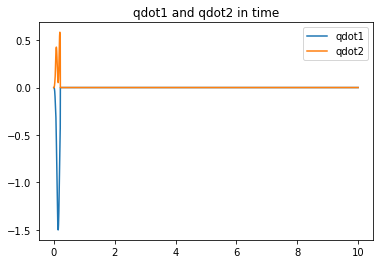

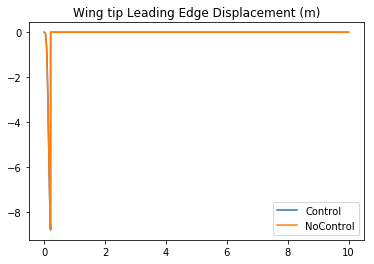

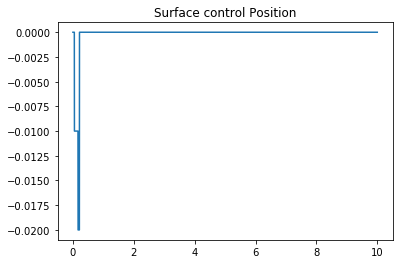

Run: 146, exploration: 0.02007268340081227, steps: 197, score: [366.99862944] , time:49.534775733947754
Run: 147, exploration: 0.019667329063911294, steps: 205, score: [375.13882501] , time:49.49627494812012
Run: 148, exploration: 0.019275942789710083, steps: 202, score: [373.23936753] , time:48.79938077926636
Run: 149, exploration: 0.018909356845622328, steps: 193, score: [410.26830589] , time:47.563966512680054
Run: 150, exploration: 0.01853676163317339, steps: 200, score: [373.00418795] , time:48.62162399291992


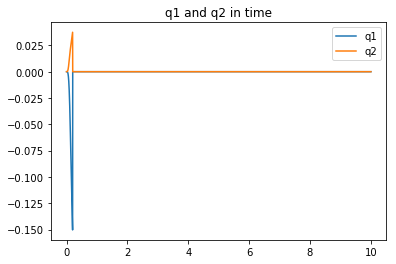

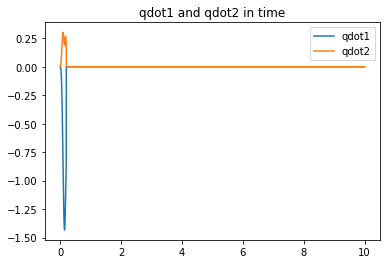

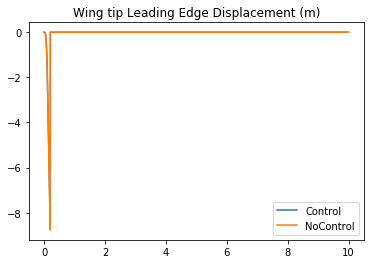

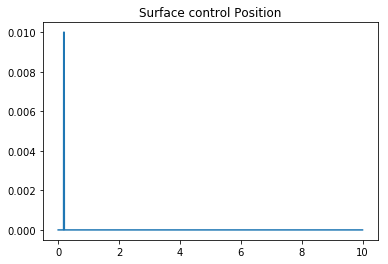

Run: 151, exploration: 0.018180596620575116, steps: 195, score: [351.36766584] , time:47.956218242645264
Run: 152, exploration: 0.017818796807750586, steps: 202, score: [373.23936753] , time:49.61508297920227
Run: 153, exploration: 0.017486916285787496, steps: 189, score: [333.73593129] , time:46.57724332809448
Run: 154, exploration: 0.017140635001768854, steps: 201, score: [373.12421937] , time:48.59014916419983
Run: 155, exploration: 0.016789453566075835, steps: 208, score: [400.94736353] , time:50.23700952529907


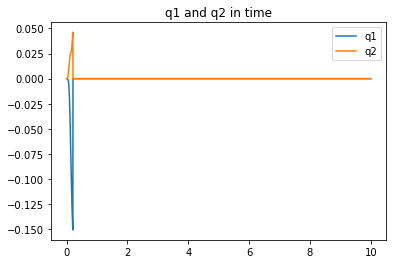

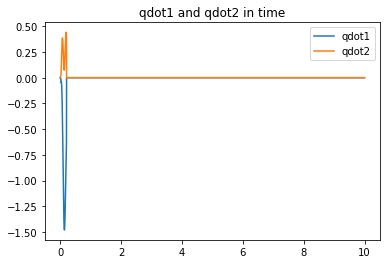

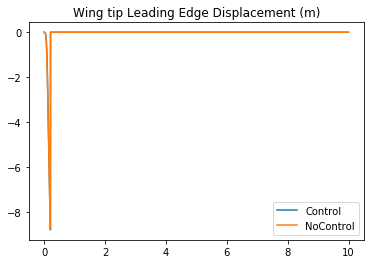

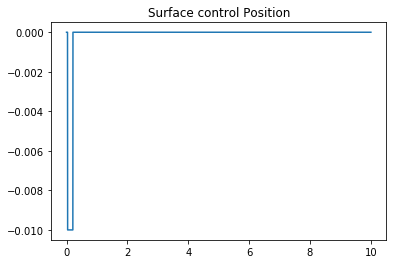

Run: 156, exploration: 0.01646521461387394, steps: 196, score: [371.37605149] , time:48.26777696609497
Run: 157, exploration: 0.016139165379980773, steps: 201, score: [329.61510448] , time:49.065027952194214
Run: 158, exploration: 0.01582590208444313, steps: 197, score: [361.36909032] , time:48.80328440666199
Run: 159, exploration: 0.015503207532437691, steps: 207, score: [387.08265962] , time:49.778098583221436
Run: 160, exploration: 0.015193169168376206, steps: 203, score: [362.76625639] , time:49.0590124130249


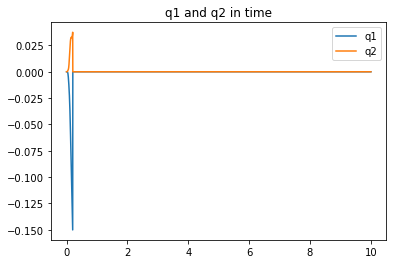

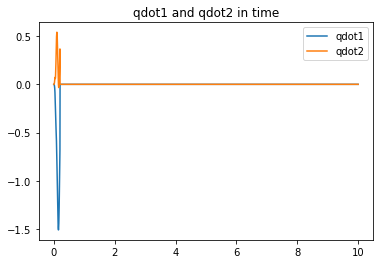

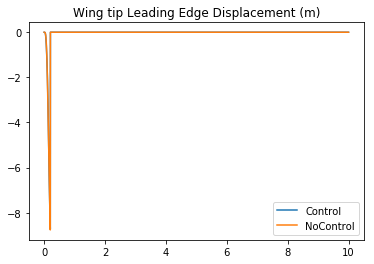

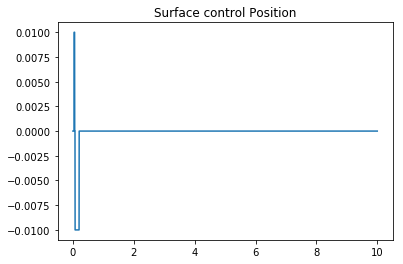

Run: 161, exploration: 0.014881887879163364, steps: 208, score: [406.97575768] , time:50.256128787994385
Run: 162, exploration: 0.01459740728744036, steps: 194, score: [348.08630575] , time:47.55336785316467
Run: 163, exploration: 0.014311207045858473, steps: 199, score: [374.13149634] , time:48.23848009109497
Run: 164, exploration: 0.014022201847774602, steps: 205, score: [374.04969507] , time:49.57859563827515
Run: 165, exploration: 0.0137335381263518, steps: 209, score: [413.71078834] , time:50.981605768203735


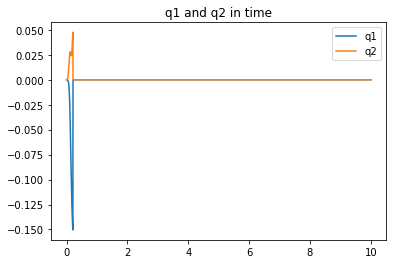

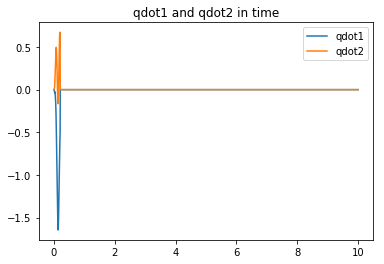

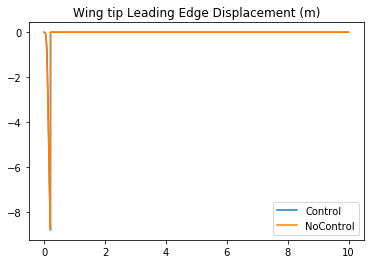

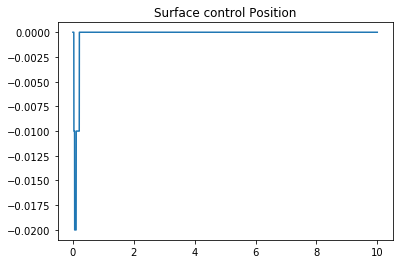

Run: 166, exploration: 0.0134656216713174, steps: 198, score: [372.25708479] , time:48.54069805145264
Run: 167, exploration: 0.013205572763574711, steps: 196, score: [332.62872332] , time:48.156925678253174
Run: 168, exploration: 0.01291562488074419, steps: 223, score: [392.62889474] , time:52.38235330581665
Run: 169, exploration: 0.012666197544596303, steps: 196, score: [372.3148385] , time:47.874677419662476
Run: 170, exploration: 0.012417861060876592, steps: 199, score: [376.99329005] , time:48.4054229259491


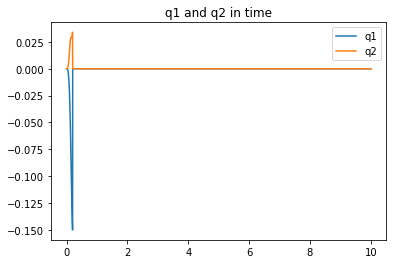

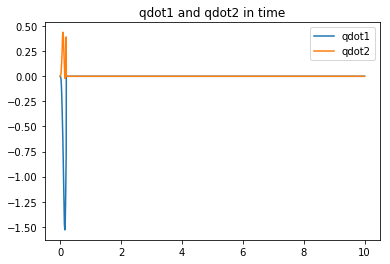

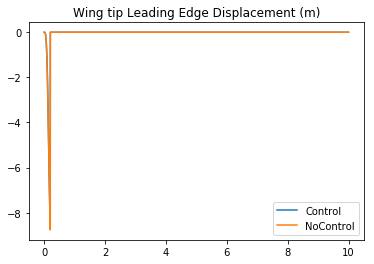

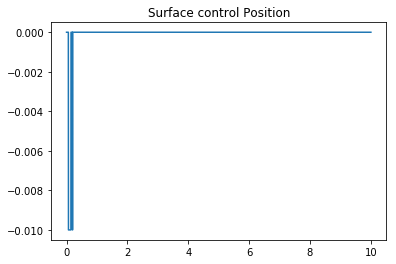

Run: 171, exploration: 0.01217074156852607, steps: 202, score: [373.23936753] , time:49.90537643432617
Run: 172, exploration: 0.011928539834813696, steps: 202, score: [373.23936753] , time:49.55977654457092
Run: 173, exploration: 0.011678304149149863, steps: 213, score: [434.6551773] , time:51.15299367904663
Run: 174, exploration: 0.011452772026504366, steps: 196, score: [372.3945201] , time:47.78171253204346
Run: 175, exploration: 0.011234965546605542, steps: 193, score: [327.66908235] , time:47.47962832450867


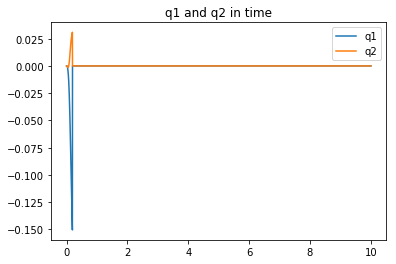

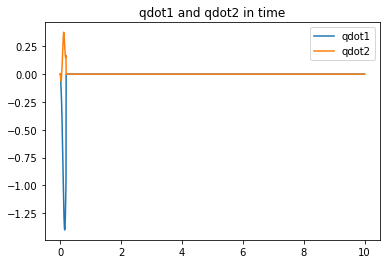

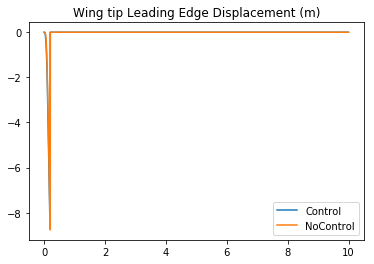

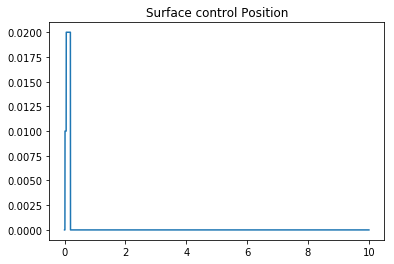

Run: 176, exploration: 0.011026813570082247, steps: 188, score: [359.96136585] , time:47.976781368255615
Run: 177, exploration: 0.010819271627265443, steps: 191, score: [371.52709921] , time:47.85917806625366
Run: 178, exploration: 0.010603964586944634, steps: 202, score: [373.23936753] , time:48.94425630569458
Run: 179, exploration: 0.010401260323560996, steps: 194, score: [373.53120242] , time:47.66065549850464
Run: 180, exploration: 0.010194271844759099, steps: 202, score: [373.23936753] , time:49.1425507068634


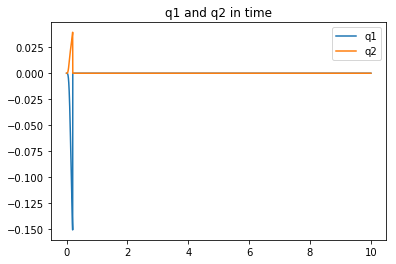

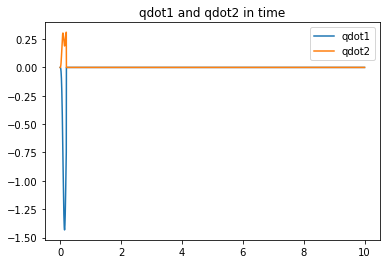

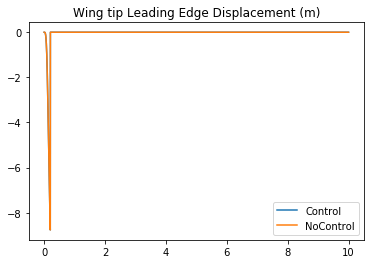

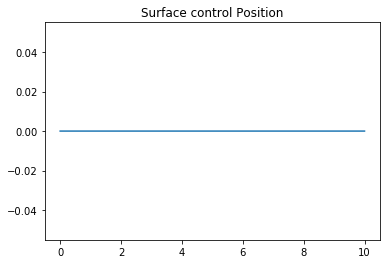

Run: 181, exploration: 0.01, steps: 196, score: [361.24746224] , time:48.34808826446533
Run: 182, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.65520524978638
Run: 183, exploration: 0.01, steps: 205, score: [374.24164208] , time:50.404529333114624
Run: 184, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.860493183135986
Run: 185, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.94048810005188


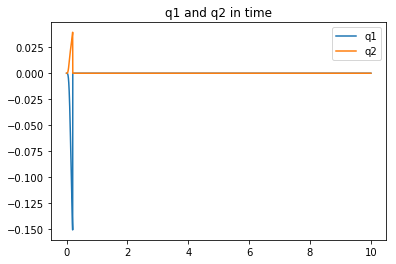

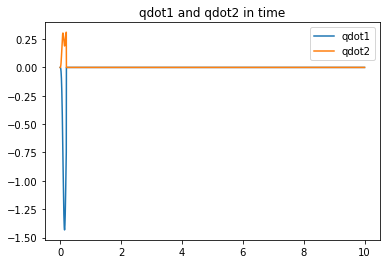

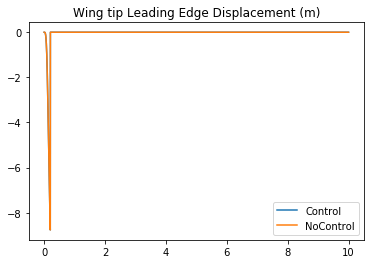

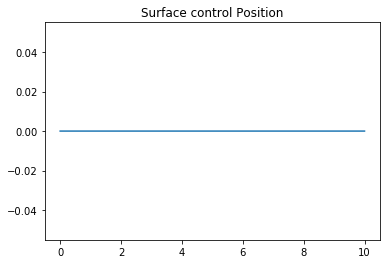

Run: 186, exploration: 0.01, steps: 208, score: [374.10540593] , time:50.603432178497314
Run: 187, exploration: 0.01, steps: 191, score: [315.81529647] , time:47.19136166572571
Run: 188, exploration: 0.01, steps: 205, score: [376.70189101] , time:49.57125377655029
Run: 189, exploration: 0.01, steps: 206, score: [373.72720863] , time:49.832345724105835
Run: 190, exploration: 0.01, steps: 198, score: [364.15327373] , time:49.41245889663696


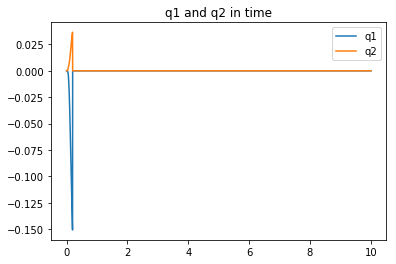

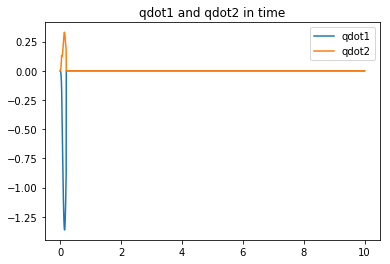

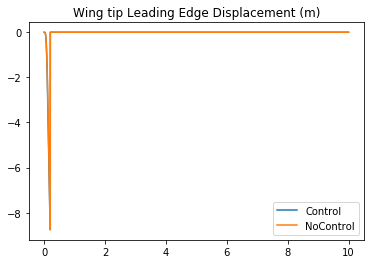

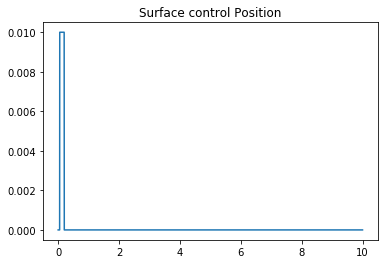

Run: 191, exploration: 0.01, steps: 199, score: [369.24983135] , time:48.96070957183838
Run: 192, exploration: 0.01, steps: 211, score: [378.21159242] , time:50.69280695915222
Run: 193, exploration: 0.01, steps: 197, score: [361.36909032] , time:48.06656241416931
Run: 194, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.148797035217285
Run: 195, exploration: 0.01, steps: 198, score: [372.75068843] , time:48.30088686943054


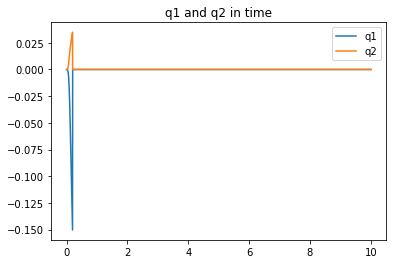

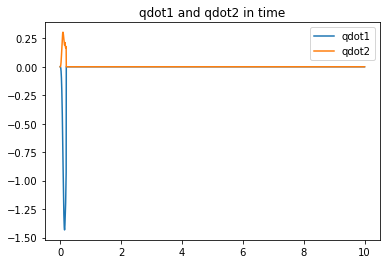

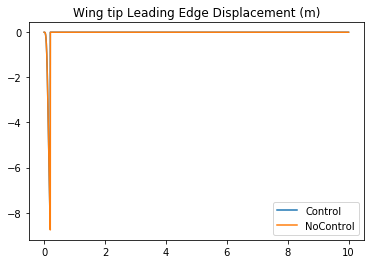

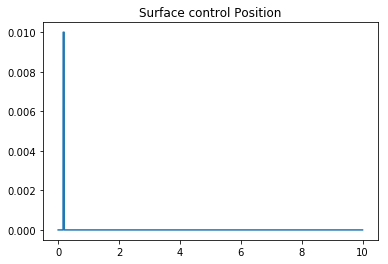

Run: 196, exploration: 0.01, steps: 189, score: [345.50577239] , time:47.708678007125854
Run: 197, exploration: 0.01, steps: 208, score: [406.97575768] , time:51.27630567550659
Run: 198, exploration: 0.01, steps: 205, score: [374.08514003] , time:49.41150259971619
Run: 199, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.26533126831055
Run: 200, exploration: 0.01, steps: 199, score: [373.68684818] , time:48.68115782737732


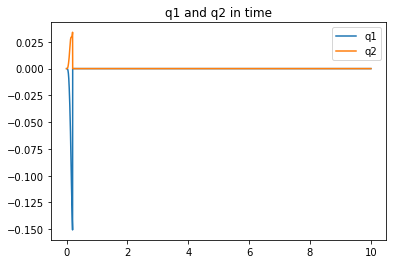

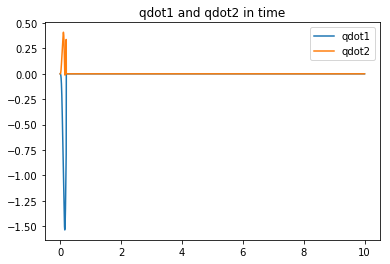

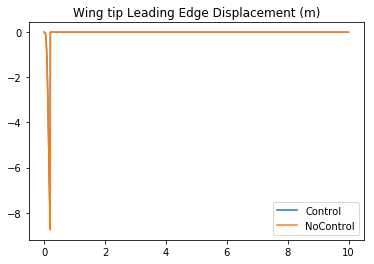

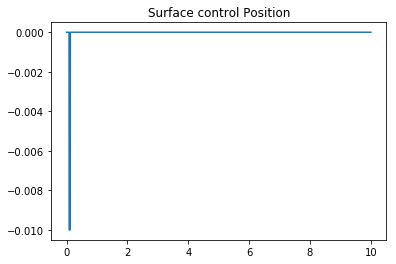

Run: 201, exploration: 0.01, steps: 196, score: [372.23692636] , time:48.67678499221802
Run: 202, exploration: 0.01, steps: 201, score: [373.12430526] , time:49.55371832847595
Run: 203, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.073933601379395
Run: 204, exploration: 0.01, steps: 199, score: [371.94723688] , time:48.602458238601685
Run: 205, exploration: 0.01, steps: 202, score: [376.03186742] , time:49.04904317855835


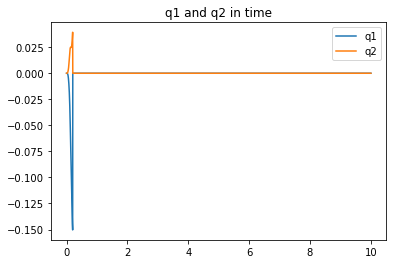

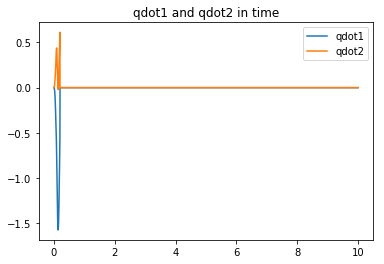

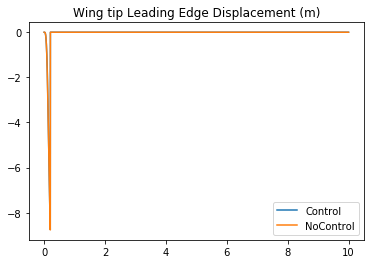

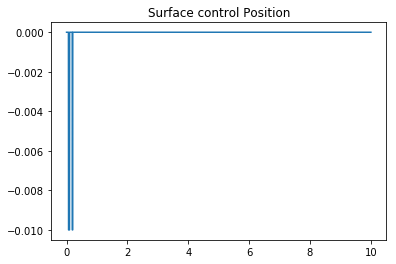

Run: 206, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.53305006027222
Run: 207, exploration: 0.01, steps: 200, score: [355.87369129] , time:48.5914204120636
Run: 208, exploration: 0.01, steps: 203, score: [373.56760966] , time:49.82221055030823
Run: 209, exploration: 0.01, steps: 196, score: [317.30862265] , time:48.643295764923096
Run: 210, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.64174485206604


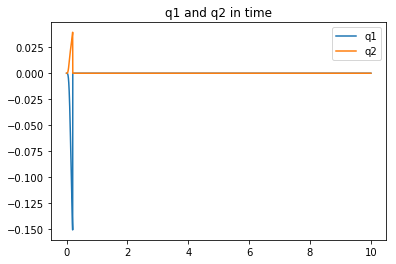

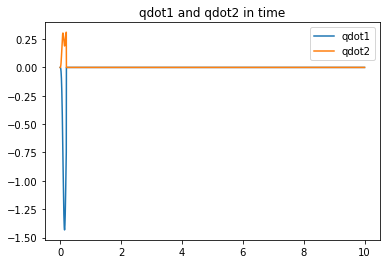

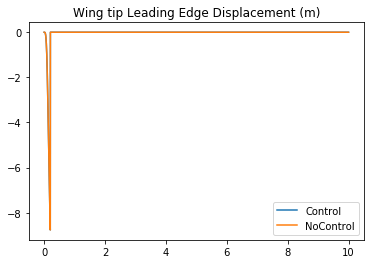

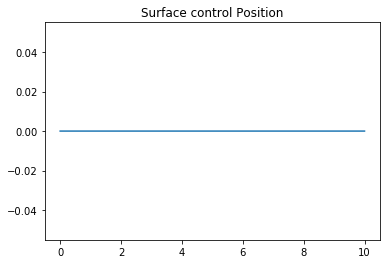

Run: 211, exploration: 0.01, steps: 205, score: [374.29842947] , time:49.879600048065186
Run: 212, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.10884952545166
Run: 213, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.941988468170166
Run: 214, exploration: 0.01, steps: 205, score: [375.81160516] , time:49.68898630142212
Run: 215, exploration: 0.01, steps: 202, score: [351.11176523] , time:49.66816473007202


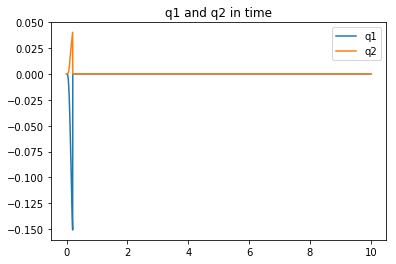

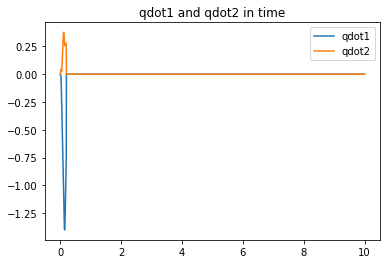

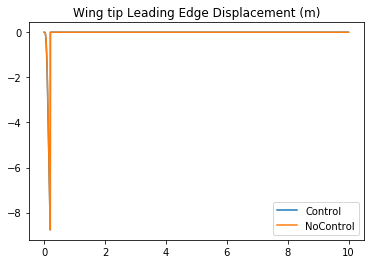

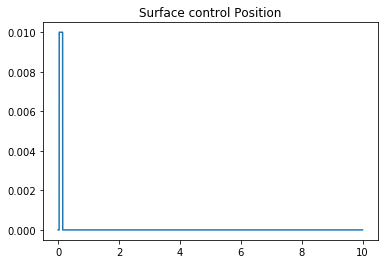

Run: 216, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.77741360664368
Run: 217, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.94647669792175
Run: 218, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.262951135635376
Run: 219, exploration: 0.01, steps: 202, score: [412.67425695] , time:48.93524932861328
Run: 220, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.92275094985962


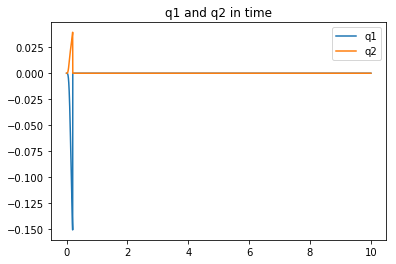

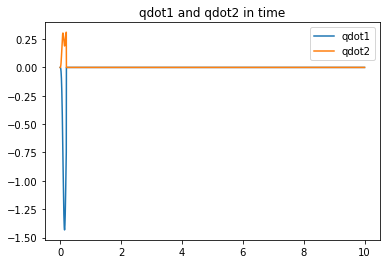

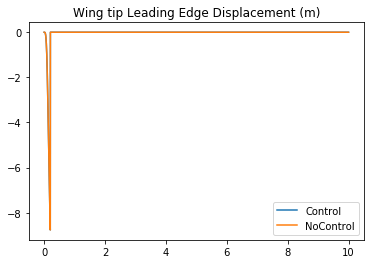

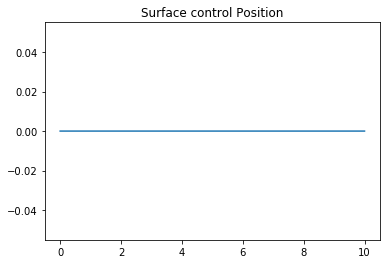

Run: 221, exploration: 0.01, steps: 202, score: [373.23936753] , time:50.47486186027527
Run: 222, exploration: 0.01, steps: 209, score: [442.67303248] , time:50.43689942359924
Run: 223, exploration: 0.01, steps: 197, score: [372.60296276] , time:48.25812840461731
Run: 224, exploration: 0.01, steps: 201, score: [382.74434763] , time:48.96063995361328
Run: 225, exploration: 0.01, steps: 198, score: [372.75273432] , time:48.14050340652466


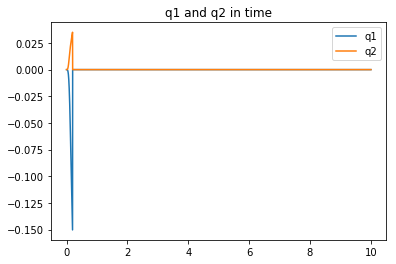

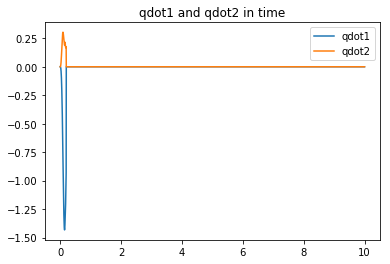

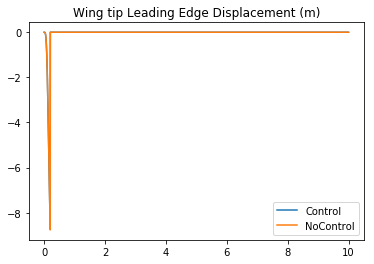

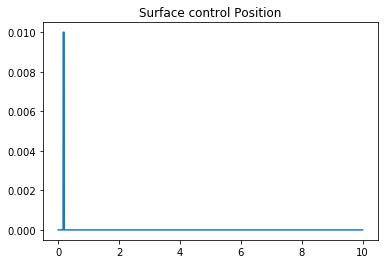

Run: 226, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.26056671142578
Run: 227, exploration: 0.01, steps: 206, score: [373.71647885] , time:50.61387038230896
Run: 228, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.93398094177246
Run: 229, exploration: 0.01, steps: 189, score: [345.87973825] , time:46.380892515182495
Run: 230, exploration: 0.01, steps: 206, score: [412.73105042] , time:49.796443462371826


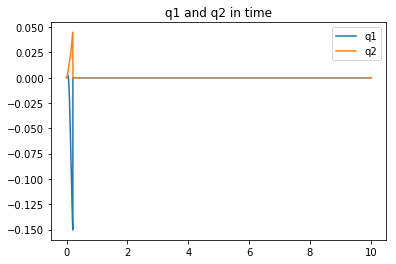

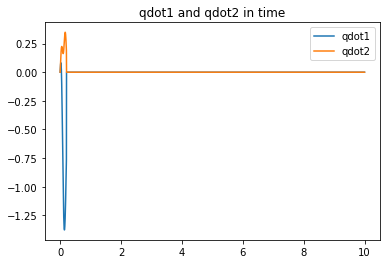

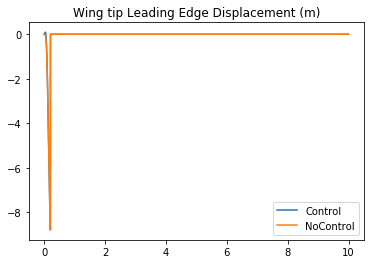

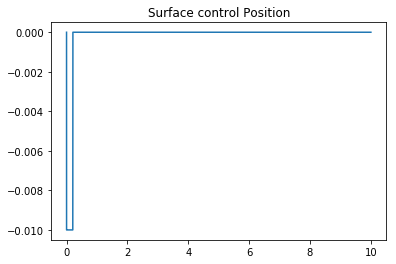

Run: 231, exploration: 0.01, steps: 213, score: [380.51325496] , time:51.458621978759766
Run: 232, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.78912329673767
Run: 233, exploration: 0.01, steps: 199, score: [372.87670803] , time:49.3544135093689
Run: 234, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.09004616737366
Run: 235, exploration: 0.01, steps: 201, score: [390.21396397] , time:48.83044791221619


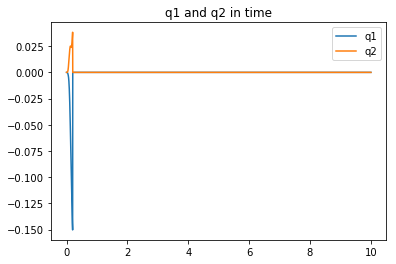

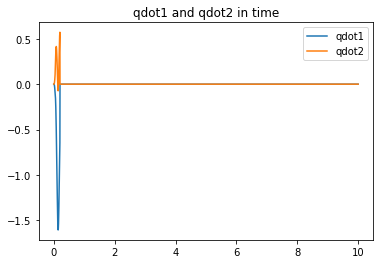

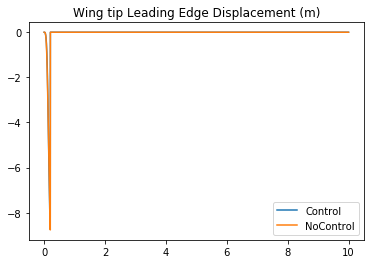

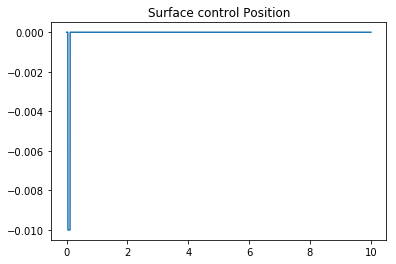

Run: 236, exploration: 0.01, steps: 208, score: [373.99936417] , time:50.31179761886597
Run: 237, exploration: 0.01, steps: 205, score: [374.43414804] , time:49.6619188785553
Run: 238, exploration: 0.01, steps: 208, score: [403.75349222] , time:50.00410318374634
Run: 239, exploration: 0.01, steps: 210, score: [394.77034207] , time:50.67274212837219
Run: 240, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.91250705718994


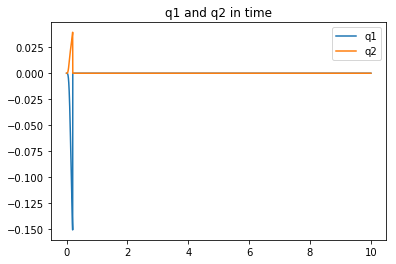

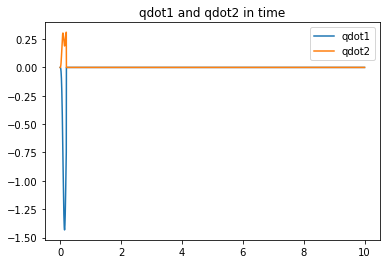

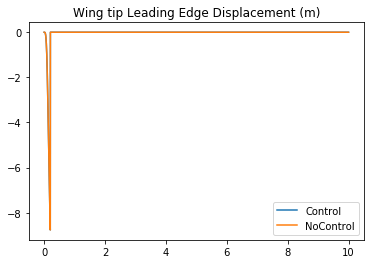

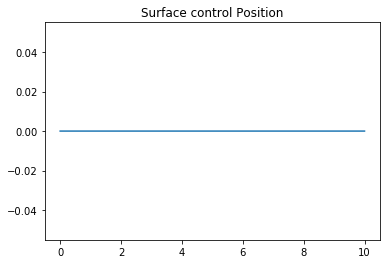

Run: 241, exploration: 0.01, steps: 199, score: [316.22100654] , time:48.68011522293091
Run: 242, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.13612627983093
Run: 243, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.25060677528381
Run: 244, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.89447379112244
Run: 245, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.76785349845886


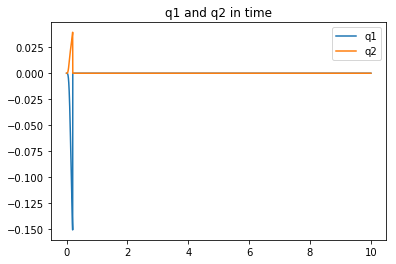

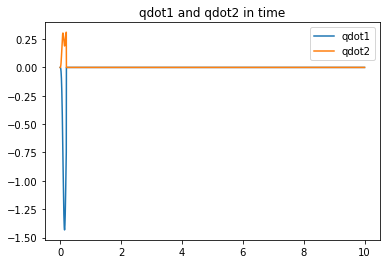

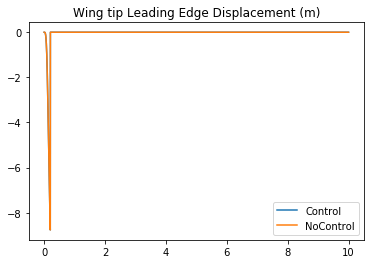

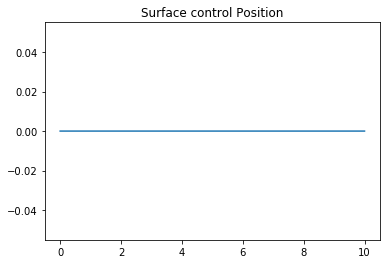

Run: 246, exploration: 0.01, steps: 196, score: [350.35107411] , time:49.56010985374451
Run: 247, exploration: 0.01, steps: 212, score: [443.34837212] , time:50.81038045883179
Run: 248, exploration: 0.01, steps: 200, score: [322.1588575] , time:49.55287480354309
Run: 249, exploration: 0.01, steps: 198, score: [334.9523466] , time:48.2718403339386
Run: 250, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.19825005531311


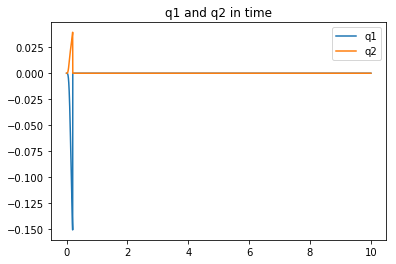

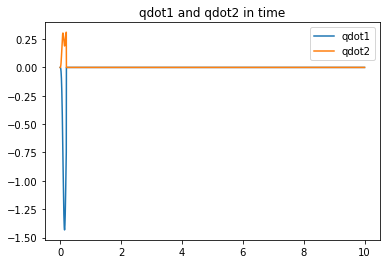

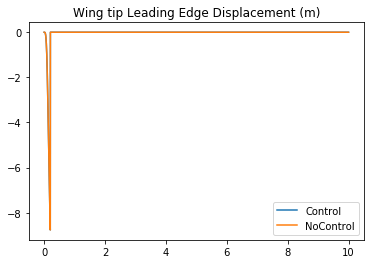

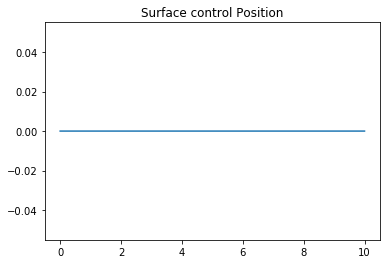

Run: 251, exploration: 0.01, steps: 204, score: [373.51701335] , time:49.67082238197327
Run: 252, exploration: 0.01, steps: 192, score: [320.53628305] , time:48.29824686050415
Run: 253, exploration: 0.01, steps: 207, score: [413.2944069] , time:49.87195611000061
Run: 254, exploration: 0.01, steps: 202, score: [373.23953271] , time:48.94834017753601
Run: 255, exploration: 0.01, steps: 208, score: [400.94736353] , time:50.06590795516968


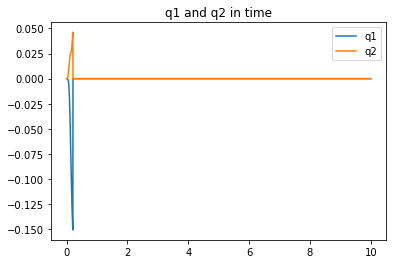

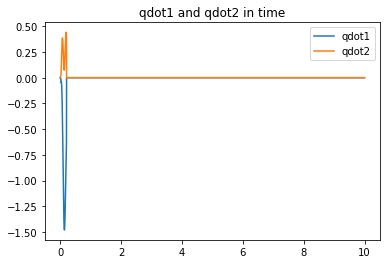

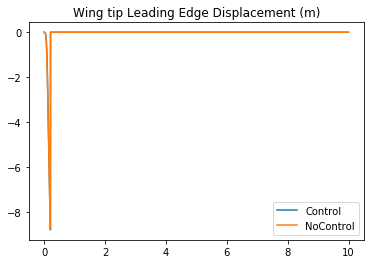

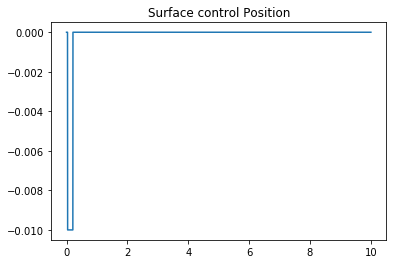

Run: 256, exploration: 0.01, steps: 204, score: [394.14828698] , time:49.7240424156189
Run: 257, exploration: 0.01, steps: 205, score: [374.51563517] , time:49.41089677810669
Run: 258, exploration: 0.01, steps: 197, score: [362.73577894] , time:48.67395520210266
Run: 259, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.13396883010864
Run: 260, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.88828897476196


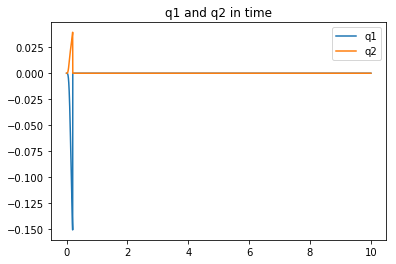

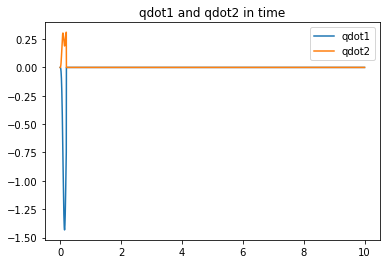

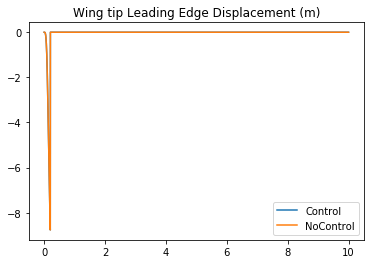

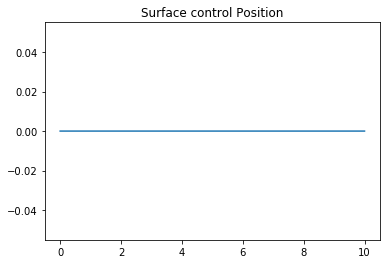

Run: 261, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.60728478431702
Run: 262, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.15262508392334
Run: 263, exploration: 0.01, steps: 208, score: [401.88779451] , time:50.01310157775879
Run: 264, exploration: 0.01, steps: 211, score: [377.98180601] , time:50.964040994644165
Run: 265, exploration: 0.01, steps: 198, score: [374.29016806] , time:48.39166617393494


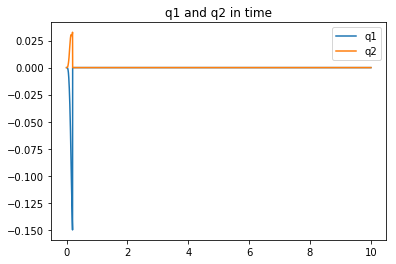

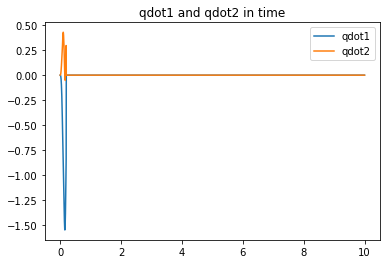

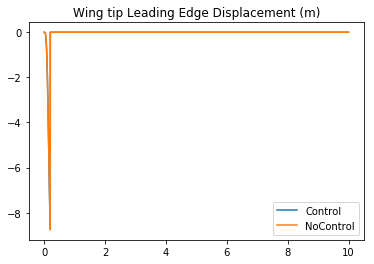

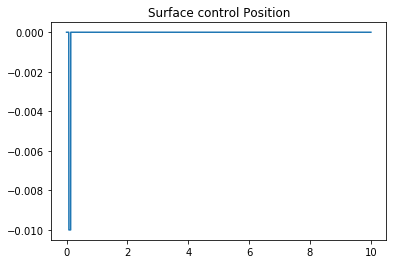

Run: 266, exploration: 0.01, steps: 206, score: [407.71294279] , time:49.961405992507935
Run: 267, exploration: 0.01, steps: 205, score: [413.01312761] , time:49.52635645866394
Run: 268, exploration: 0.01, steps: 198, score: [367.39640044] , time:48.45754933357239
Run: 269, exploration: 0.01, steps: 201, score: [373.12467875] , time:48.75419473648071
Run: 270, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.0052170753479


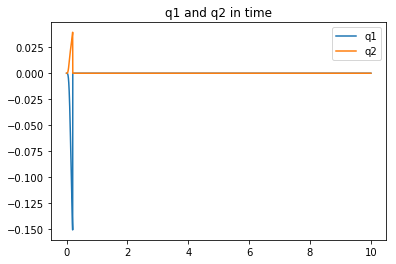

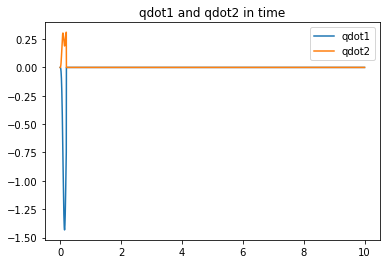

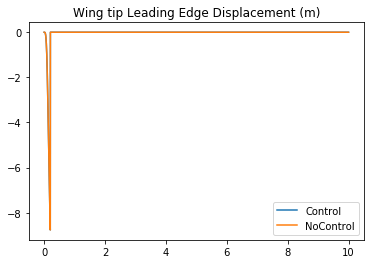

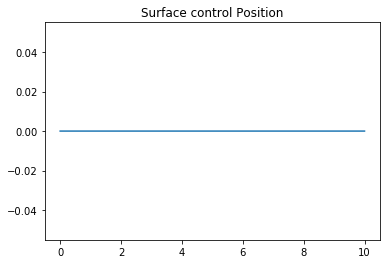

Run: 271, exploration: 0.01, steps: 205, score: [374.16747544] , time:50.56006169319153
Run: 272, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.16092777252197
Run: 273, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.99412441253662
Run: 274, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.720391273498535
Run: 275, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.89735388755798


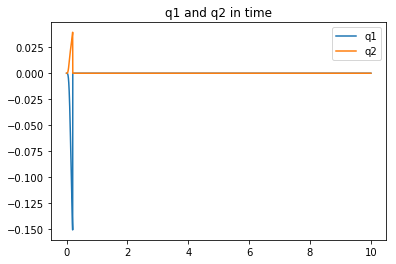

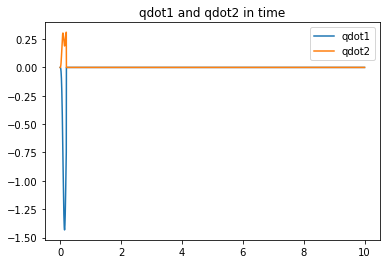

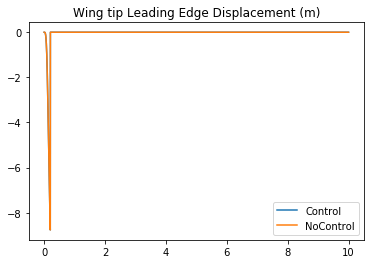

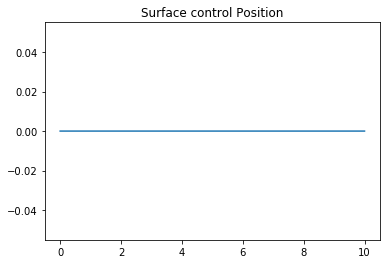

Run: 276, exploration: 0.01, steps: 208, score: [374.03379277] , time:50.31850790977478
Run: 277, exploration: 0.01, steps: 207, score: [377.90363344] , time:50.54181432723999
Run: 278, exploration: 0.01, steps: 202, score: [377.17579305] , time:48.930168867111206
Run: 279, exploration: 0.01, steps: 197, score: [372.60296276] , time:47.92811846733093
Run: 280, exploration: 0.01, steps: 205, score: [374.36221001] , time:49.35368299484253


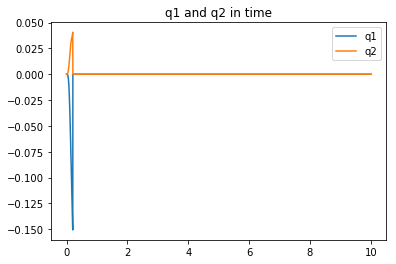

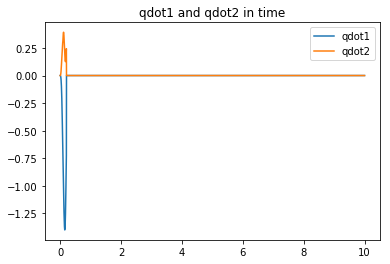

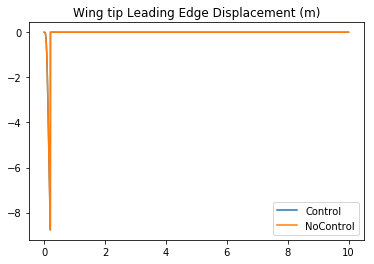

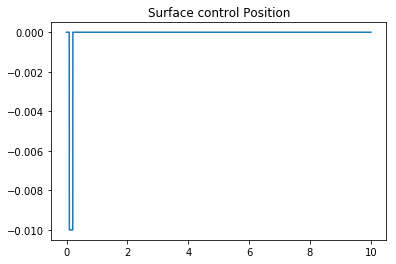

Run: 281, exploration: 0.01, steps: 208, score: [374.11920449] , time:50.34783315658569
Run: 282, exploration: 0.01, steps: 209, score: [377.13496643] , time:50.13209652900696
Run: 283, exploration: 0.01, steps: 202, score: [375.51713759] , time:49.59613060951233
Run: 284, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.00394248962402
Run: 285, exploration: 0.01, steps: 205, score: [375.55020845] , time:49.29562187194824


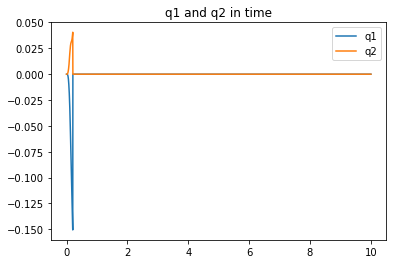

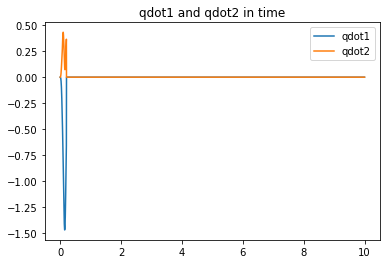

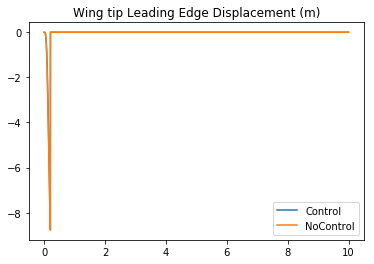

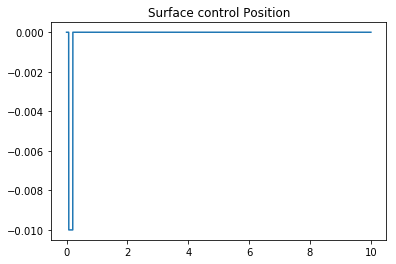

Run: 286, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.50565552711487
Run: 287, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.810227394104004
Run: 288, exploration: 0.01, steps: 196, score: [335.74459809] , time:47.89788055419922
Run: 289, exploration: 0.01, steps: 208, score: [374.1185153] , time:50.79965901374817
Run: 290, exploration: 0.01, steps: 196, score: [372.24788277] , time:47.802645444869995


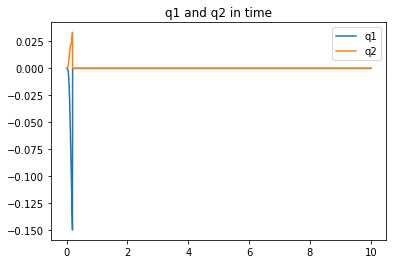

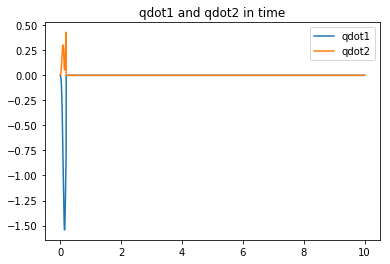

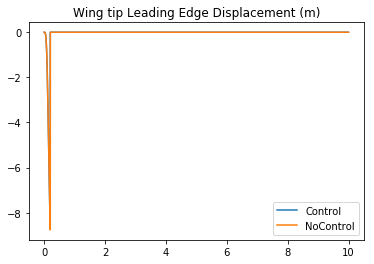

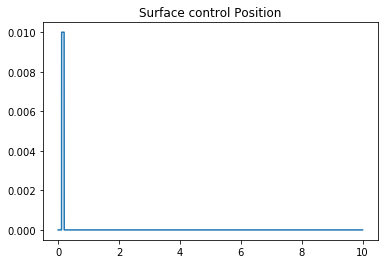

Run: 291, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.717926025390625
Run: 292, exploration: 0.01, steps: 207, score: [373.85762707] , time:49.51813840866089
Run: 293, exploration: 0.01, steps: 208, score: [374.00330645] , time:50.08112621307373
Run: 294, exploration: 0.01, steps: 197, score: [362.73577894] , time:47.74979877471924
Run: 295, exploration: 0.01, steps: 191, score: [346.78817578] , time:47.15904760360718


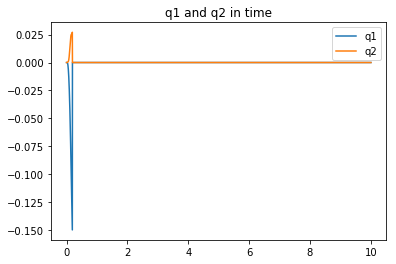

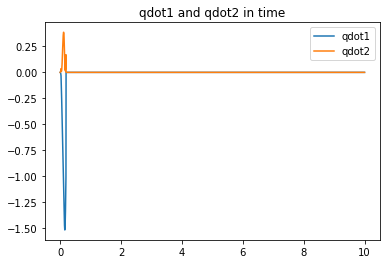

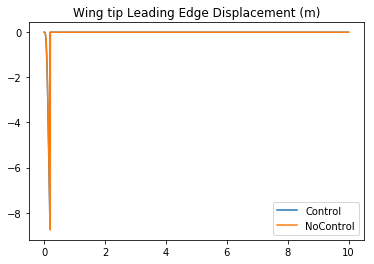

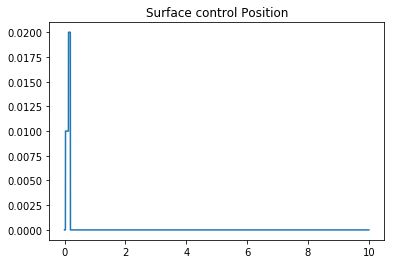

Run: 296, exploration: 0.01, steps: 195, score: [375.10512171] , time:48.65594220161438
Run: 297, exploration: 0.01, steps: 200, score: [384.30590365] , time:49.00251269340515
Run: 298, exploration: 0.01, steps: 202, score: [337.54470882] , time:49.17964482307434
Run: 299, exploration: 0.01, steps: 204, score: [392.41613768] , time:48.95886206626892
Run: 300, exploration: 0.01, steps: 203, score: [411.99369802] , time:48.960654497146606


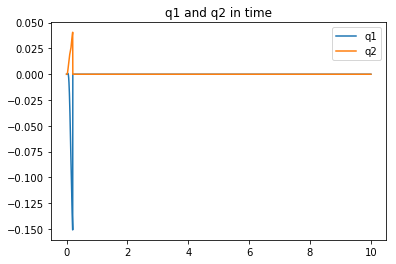

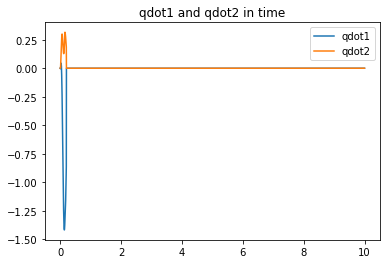

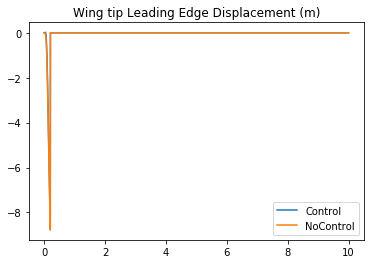

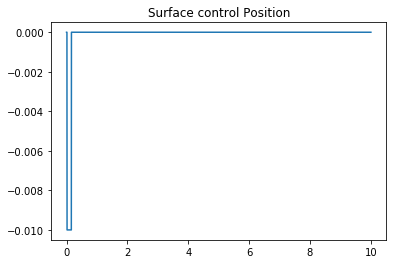

Run: 301, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.373682498931885
Run: 302, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.686864376068115
Run: 303, exploration: 0.01, steps: 205, score: [374.24164208] , time:49.39724326133728
Run: 304, exploration: 0.01, steps: 199, score: [371.21434049] , time:48.48966145515442
Run: 305, exploration: 0.01, steps: 215, score: [393.30982716] , time:51.14134883880615


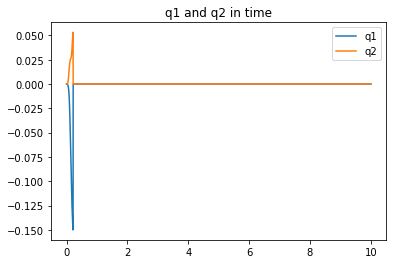

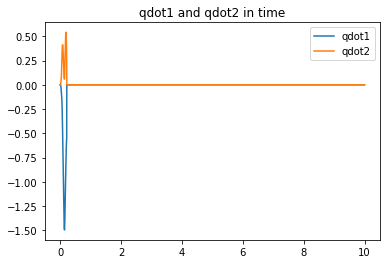

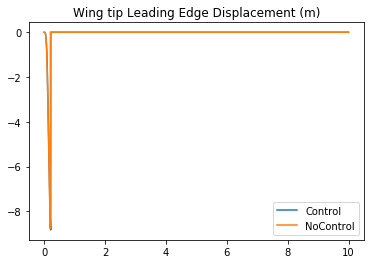

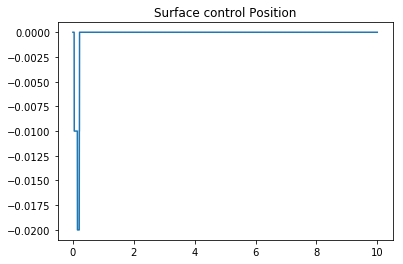

Run: 306, exploration: 0.01, steps: 196, score: [372.41777264] , time:48.379207134246826
Run: 307, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.9362108707428
Run: 308, exploration: 0.01, steps: 200, score: [359.4939435] , time:49.11518740653992
Run: 309, exploration: 0.01, steps: 214, score: [374.85027447] , time:50.690394163131714
Run: 310, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.78831124305725


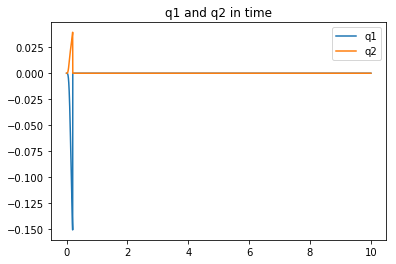

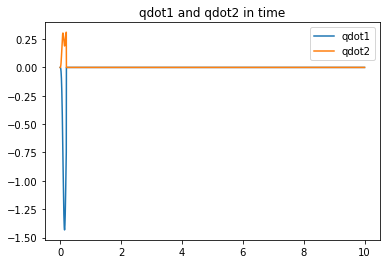

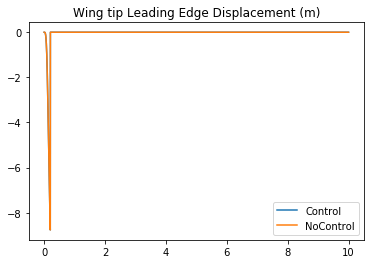

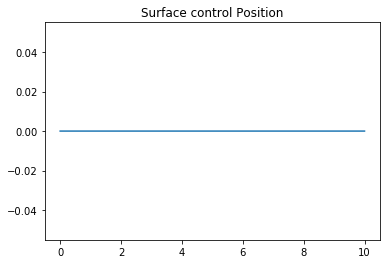

Run: 311, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.482757806777954
Run: 312, exploration: 0.01, steps: 206, score: [413.44377241] , time:49.63603138923645
Run: 313, exploration: 0.01, steps: 205, score: [372.86797643] , time:49.23415017127991
Run: 314, exploration: 0.01, steps: 197, score: [326.84623892] , time:48.53180241584778
Run: 315, exploration: 0.01, steps: 208, score: [410.99119898] , time:49.806901693344116


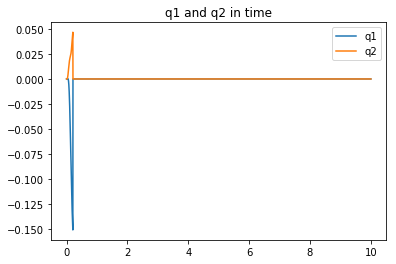

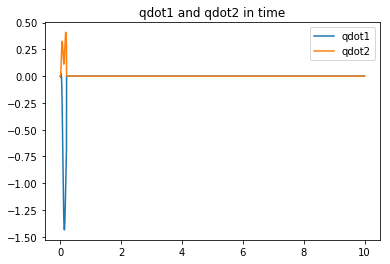

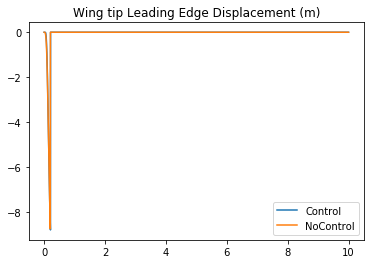

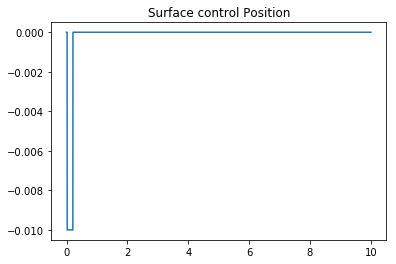

Run: 316, exploration: 0.01, steps: 198, score: [365.92866385] , time:49.00387620925903
Run: 317, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.47413611412048
Run: 318, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.664939641952515
Run: 319, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.034016609191895
Run: 320, exploration: 0.01, steps: 199, score: [371.39387808] , time:48.87587928771973


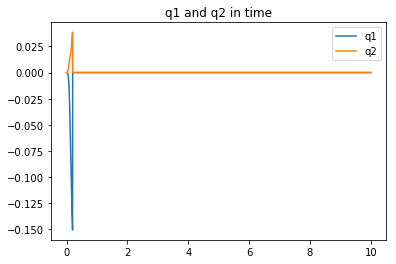

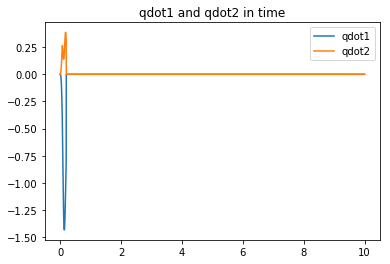

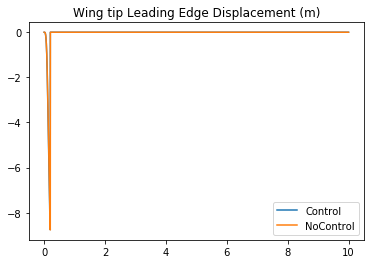

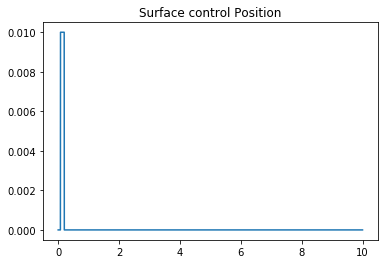

Run: 321, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.62926483154297
Run: 322, exploration: 0.01, steps: 205, score: [373.59887739] , time:49.5742506980896
Run: 323, exploration: 0.01, steps: 208, score: [374.07534075] , time:50.1214759349823
Run: 324, exploration: 0.01, steps: 208, score: [406.23314699] , time:49.680089235305786
Run: 325, exploration: 0.01, steps: 198, score: [363.51167145] , time:48.157464265823364


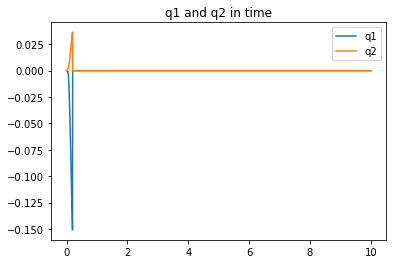

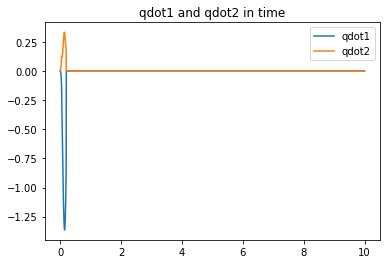

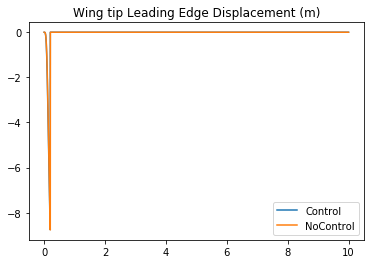

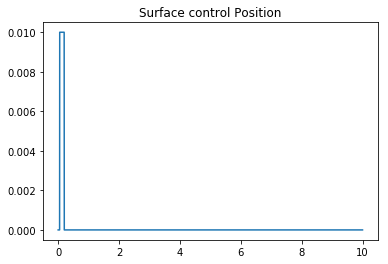

Run: 326, exploration: 0.01, steps: 202, score: [377.17335883] , time:49.20712876319885
Run: 327, exploration: 0.01, steps: 200, score: [373.00489999] , time:49.35681939125061
Run: 328, exploration: 0.01, steps: 213, score: [433.31578494] , time:51.3254497051239
Run: 329, exploration: 0.01, steps: 192, score: [372.00754169] , time:47.047802209854126
Run: 330, exploration: 0.01, steps: 219, score: [407.56148279] , time:52.04777789115906


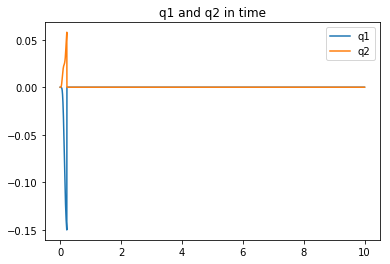

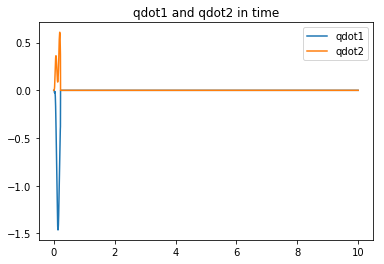

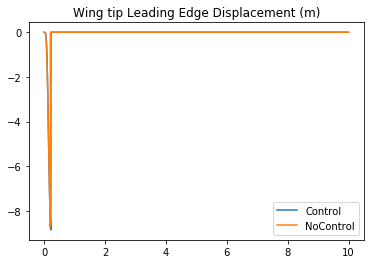

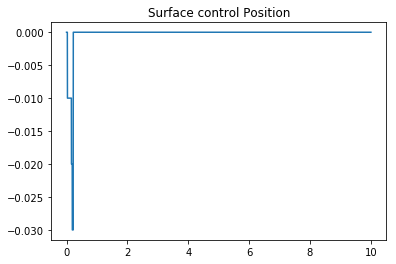

Run: 331, exploration: 0.01, steps: 209, score: [376.06580487] , time:50.67240238189697
Run: 332, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.11118412017822
Run: 333, exploration: 0.01, steps: 197, score: [372.61549618] , time:49.02665448188782
Run: 334, exploration: 0.01, steps: 198, score: [372.27680351] , time:48.92870831489563
Run: 335, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.59585356712341


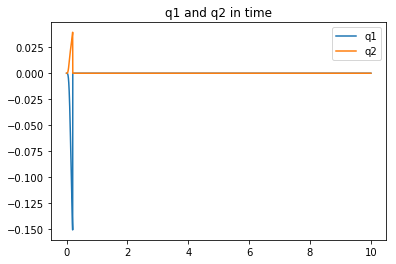

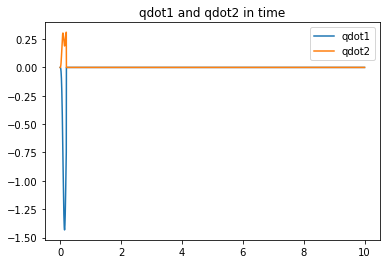

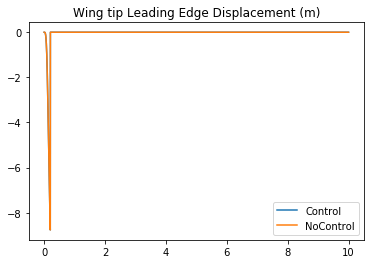

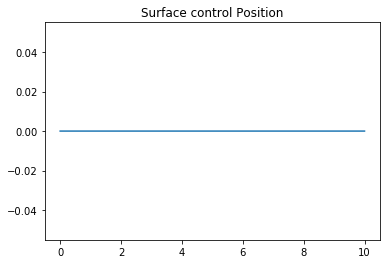

Run: 336, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.38181805610657
Run: 337, exploration: 0.01, steps: 216, score: [386.01671576] , time:51.39991903305054
Run: 338, exploration: 0.01, steps: 208, score: [373.62555497] , time:49.900368213653564
Run: 339, exploration: 0.01, steps: 198, score: [371.91634144] , time:48.86926460266113
Run: 340, exploration: 0.01, steps: 201, score: [373.1228363] , time:49.1292667388916


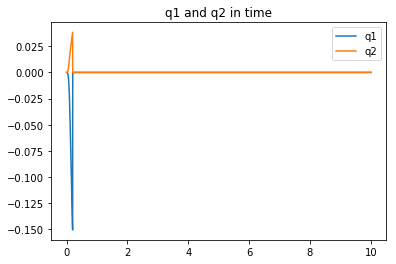

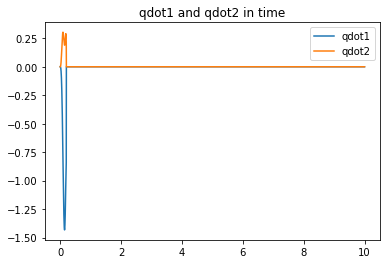

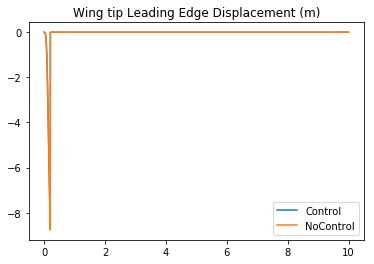

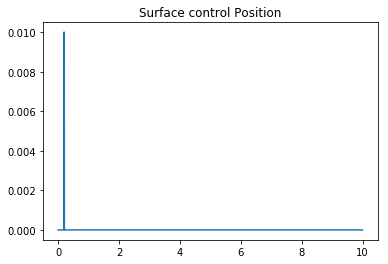

Run: 341, exploration: 0.01, steps: 194, score: [350.10449912] , time:48.182860374450684
Run: 342, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.196112871170044
Run: 343, exploration: 0.01, steps: 201, score: [373.12457786] , time:48.794702768325806
Run: 344, exploration: 0.01, steps: 198, score: [372.68913626] , time:48.11216449737549
Run: 345, exploration: 0.01, steps: 198, score: [366.94955352] , time:49.05558180809021


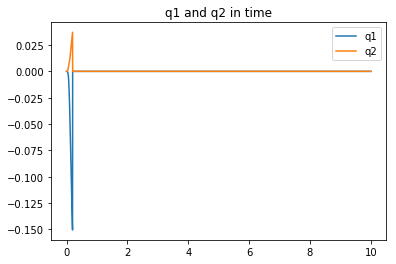

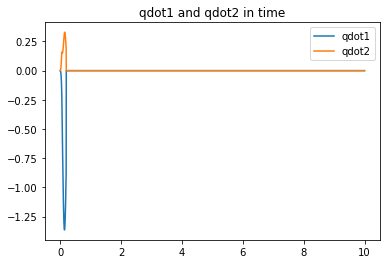

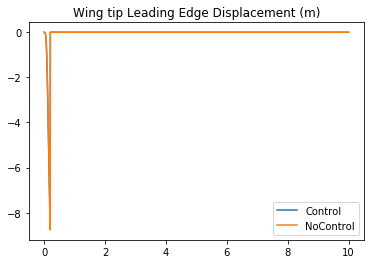

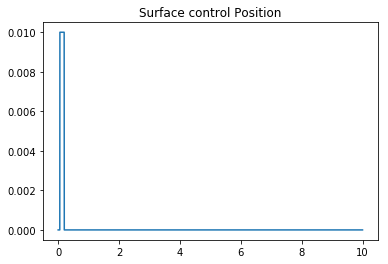

Run: 346, exploration: 0.01, steps: 196, score: [372.41777264] , time:48.31970810890198
Run: 347, exploration: 0.01, steps: 203, score: [373.35757377] , time:49.12500047683716
Run: 348, exploration: 0.01, steps: 208, score: [374.01574531] , time:50.242077112197876
Run: 349, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.713080167770386
Run: 350, exploration: 0.01, steps: 194, score: [371.60864802] , time:47.482993364334106


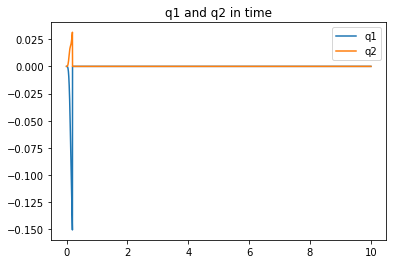

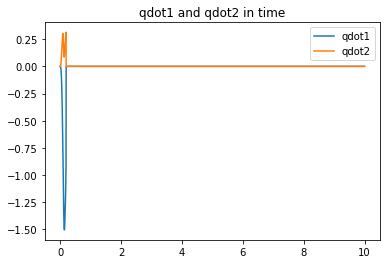

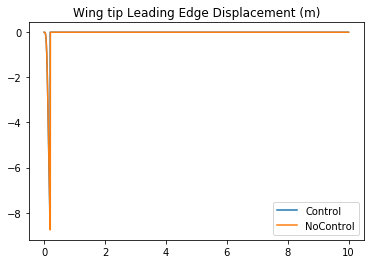

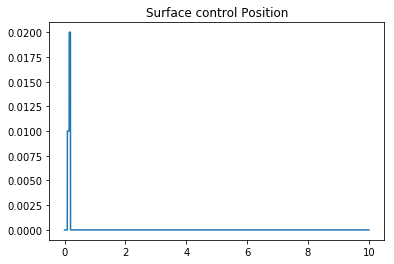

Run: 351, exploration: 0.01, steps: 197, score: [372.59598355] , time:48.57001066207886
Run: 352, exploration: 0.01, steps: 202, score: [373.23936753] , time:50.09386348724365
Run: 353, exploration: 0.01, steps: 204, score: [374.59970407] , time:49.27810597419739
Run: 354, exploration: 0.01, steps: 210, score: [380.02442948] , time:50.33044147491455
Run: 355, exploration: 0.01, steps: 198, score: [345.5071839] , time:48.43238091468811


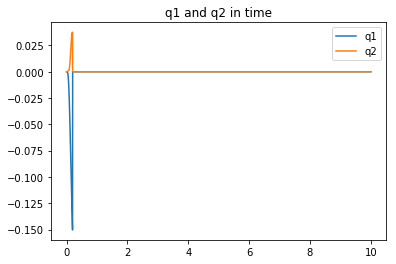

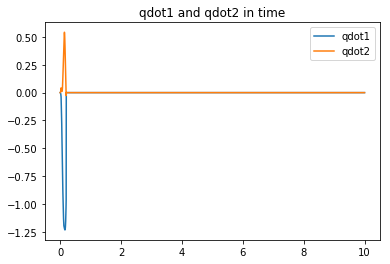

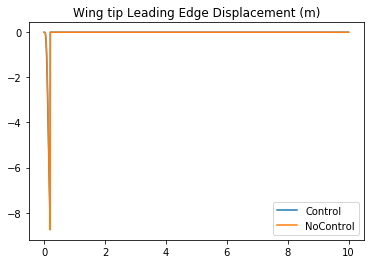

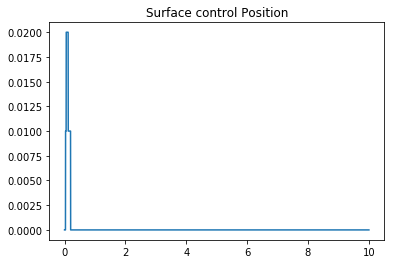

Run: 356, exploration: 0.01, steps: 198, score: [367.88630064] , time:48.84859585762024
Run: 357, exploration: 0.01, steps: 209, score: [335.45225372] , time:50.28719878196716
Run: 358, exploration: 0.01, steps: 204, score: [374.493757] , time:50.49806356430054
Run: 359, exploration: 0.01, steps: 197, score: [362.21801287] , time:48.651729583740234
Run: 360, exploration: 0.01, steps: 210, score: [407.20821235] , time:50.35501217842102


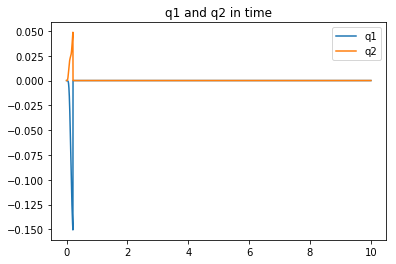

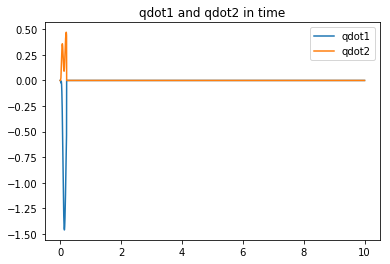

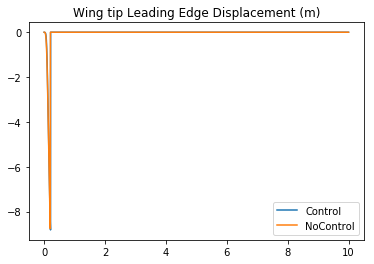

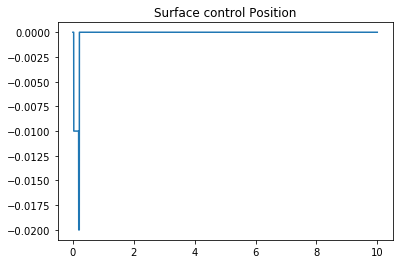

Run: 361, exploration: 0.01, steps: 202, score: [373.23942201] , time:49.45075583457947
Run: 362, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.344669342041016
Run: 363, exploration: 0.01, steps: 211, score: [399.45822366] , time:50.91952919960022
Run: 364, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.5560188293457
Run: 365, exploration: 0.01, steps: 199, score: [346.23380036] , time:48.56699061393738


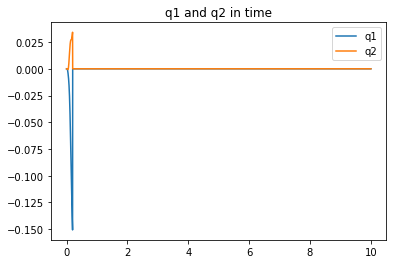

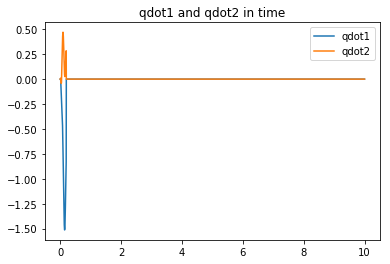

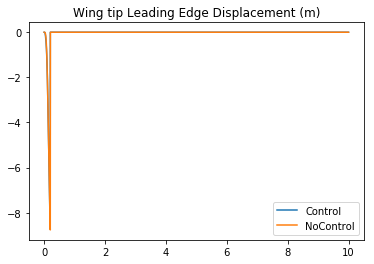

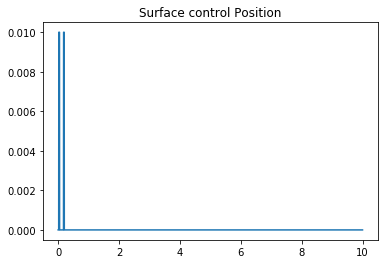

Run: 366, exploration: 0.01, steps: 203, score: [360.65400612] , time:49.432554483413696
Run: 367, exploration: 0.01, steps: 208, score: [374.02912074] , time:49.80333137512207
Run: 368, exploration: 0.01, steps: 203, score: [373.35928177] , time:49.028608083724976
Run: 369, exploration: 0.01, steps: 193, score: [337.32434952] , time:47.43127393722534
Run: 370, exploration: 0.01, steps: 211, score: [404.98038232] , time:51.087541580200195


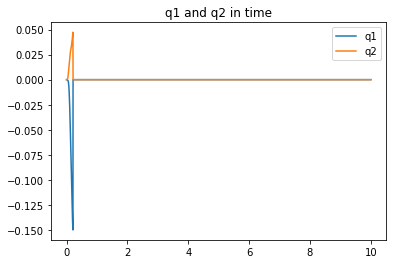

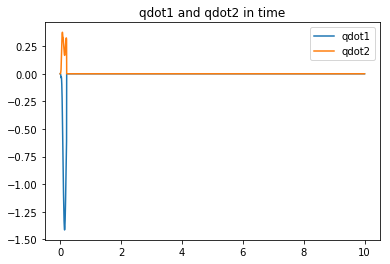

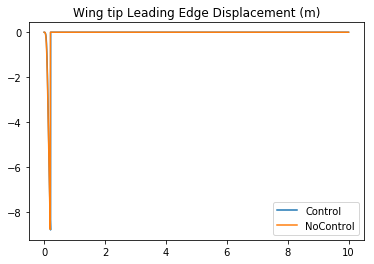

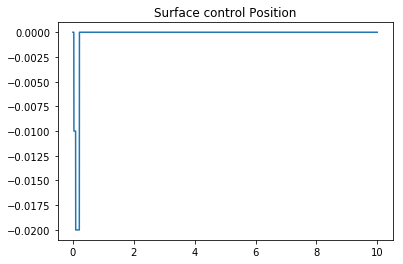

Run: 371, exploration: 0.01, steps: 198, score: [372.05633365] , time:48.71568584442139
Run: 372, exploration: 0.01, steps: 201, score: [373.12375741] , time:49.065436124801636
Run: 373, exploration: 0.01, steps: 197, score: [372.61253778] , time:48.236576795578
Run: 374, exploration: 0.01, steps: 214, score: [431.70341437] , time:51.47582459449768
Run: 375, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.296122312545776


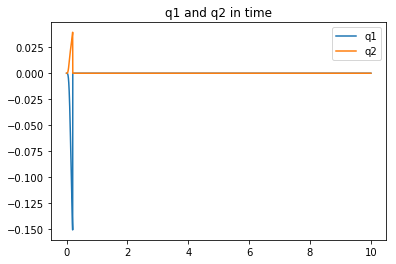

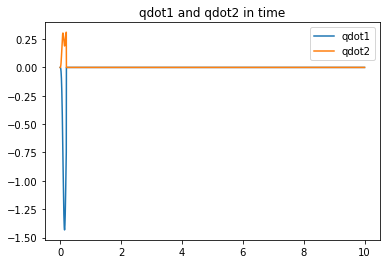

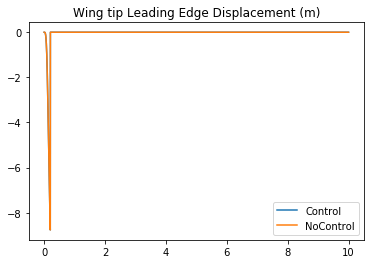

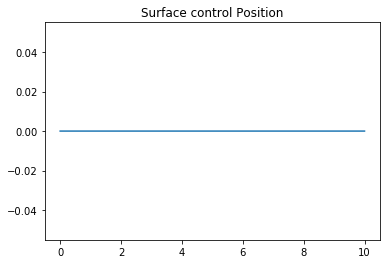

Run: 376, exploration: 0.01, steps: 202, score: [373.23936753] , time:50.346134424209595
Run: 377, exploration: 0.01, steps: 199, score: [373.61131637] , time:48.49539256095886
Run: 378, exploration: 0.01, steps: 197, score: [354.92510278] , time:48.207510471343994
Run: 379, exploration: 0.01, steps: 196, score: [350.35107411] , time:48.1655547618866
Run: 380, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.20663261413574


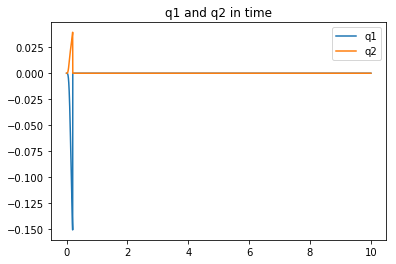

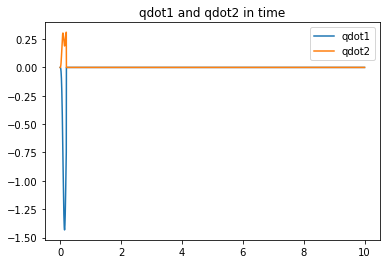

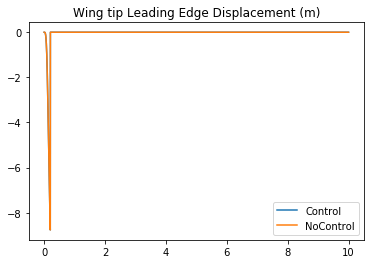

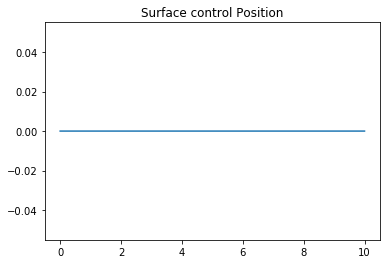

Run: 381, exploration: 0.01, steps: 208, score: [374.08102934] , time:50.420310974121094
Run: 382, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.698378801345825
Run: 383, exploration: 0.01, steps: 197, score: [372.23204605] , time:49.42922306060791
Run: 384, exploration: 0.01, steps: 196, score: [320.9311315] , time:48.0066020488739
Run: 385, exploration: 0.01, steps: 206, score: [414.96965444] , time:49.60633397102356


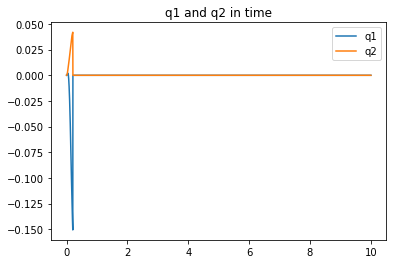

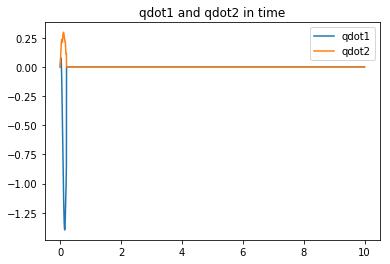

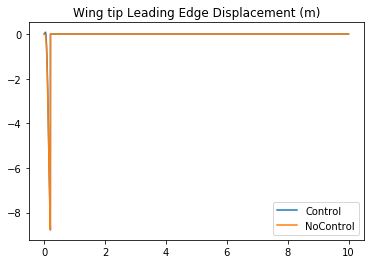

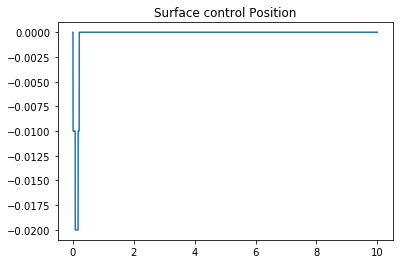

Run: 386, exploration: 0.01, steps: 204, score: [395.88358149] , time:49.94384551048279
Run: 387, exploration: 0.01, steps: 196, score: [352.80178331] , time:47.85472869873047
Run: 388, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.00951313972473
Run: 389, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.80626702308655
Run: 390, exploration: 0.01, steps: 202, score: [373.23936753] , time:48.64159440994263


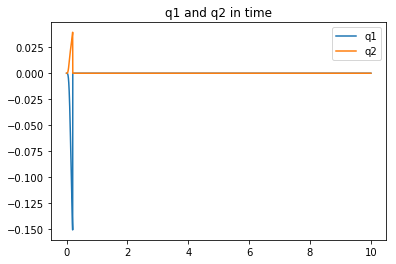

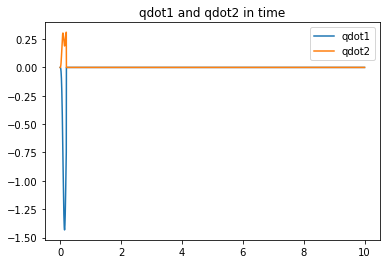

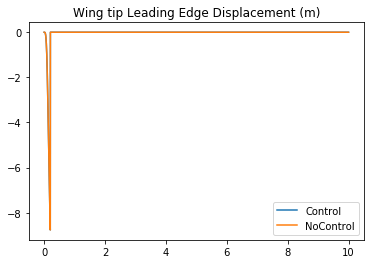

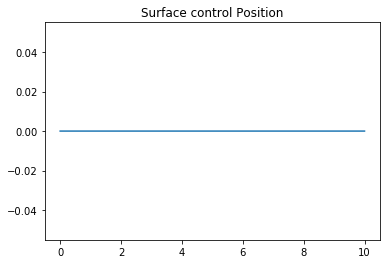

Run: 391, exploration: 0.01, steps: 207, score: [394.45360745] , time:51.009591817855835
Run: 392, exploration: 0.01, steps: 202, score: [373.23942201] , time:48.94129800796509
Run: 393, exploration: 0.01, steps: 212, score: [405.71205458] , time:50.80483078956604
Run: 394, exploration: 0.01, steps: 202, score: [373.23936753] , time:49.42977523803711
Run: 395, exploration: 0.01, steps: 210, score: [358.05742062] , time:50.960126638412476


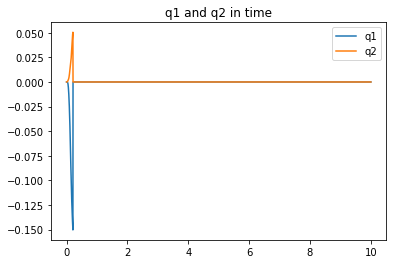

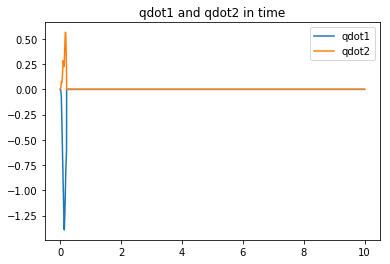

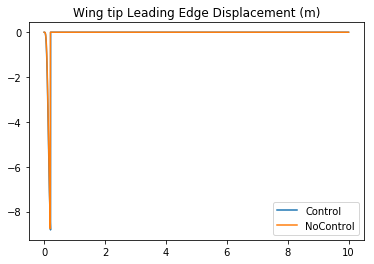

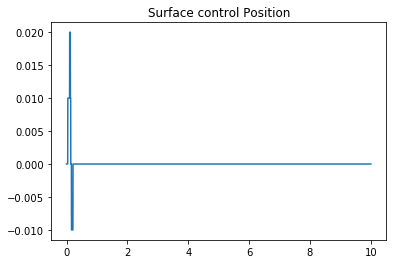

Run: 396, exploration: 0.01, steps: 188, score: [316.85921271] , time:50.278764486312866


KeyboardInterrupt: 

In [15]:
while True:
    start_time = time.time()
    scoreLog.log(env.score, run, duration)
    scoreLog.logwrite()
    scoreLog.logclose()
    if (run%5 == 0):
        #plots in the jupyter notebook the result each 5 games
        env.render()
    if (run%1 == 0):
        dqn_solver.model.save(DQN_SAVE_FILE)
        counter_dqn +=1 
        DQN_SAVE_FILE = filepath + '/' + DQN_SAVE + str(counter_dqn) +'.h5'
        FILENAME = filepath + '/' + DQN_SAVE + str(counter_dqn)
        env.plot(FILENAME)
        filename_play = filepath + '/' + 'Gameplay/' + DQN_SAVE + 'gameplay_'+ str(counter_play)
        play_one(filename_play) #saves plots of playing mode
        counter_play +=1
        
    run += 1
    state = env.reset()
    beta = env.beta
    state = np.reshape(np.append(beta,state), [1, observation_space])
    step = 0
    if run > 100000:
        break
        
   
    while True:
        step += 1
        #env.render()
        action = dqn_solver.act(state)
        #action = 0
        state_next, reward, terminal, info = env.step(action)
        reward = reward# if not terminal else -reward
        state_next = np.reshape(np.append(env.beta,state_next), [1, observation_space])
        dqn_solver.remember(state, action, reward, state_next, terminal)
        state = state_next
        if terminal or step>1500:
            end_time = time.time()
            duration = end_time-start_time
            print ("Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", steps: " + str(step) + ", score: " + str(env.score), ", time:" + str(duration))
            #score_logger.add_score(step, run)
            break
        #if step%10 == 0:
        dqn_solver.experience_replay()
print('End')

# Loading Neural Network

The code hereon presented is responsible for loading an already saved neural network. 

In [71]:
from keras.models import load_model

DQN_SAVE = "dqn_PCC_toy_R6-1_"
filepath = 'NN/'+ DQN_SAVE

DQN_SAVE_FILE = filepath + '/' + DQN_SAVE + input() + '.h5'
dqn_solver.model = load_model(DQN_SAVE_FILE)

67


In [15]:
dqn_solver.model.summary() #show the structure of the loaded neural network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 9)                 54        
_________________________________________________________________
dense_9 (Dense)              (None, 18)                180       
_________________________________________________________________
dense_10 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_11 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_12 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_13 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_14 (Dense)             (None, 18)                342       
__________

# Tests

## Notebook tests

These codes are responsible for testing the neural networks obtained in the wanted conditions

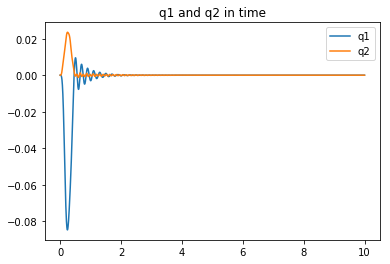

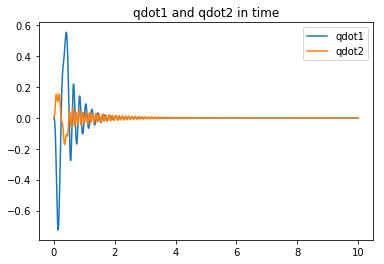

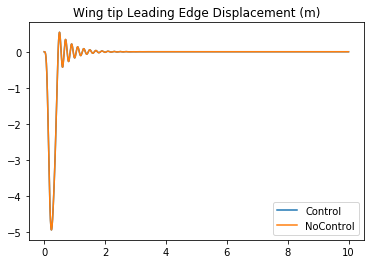

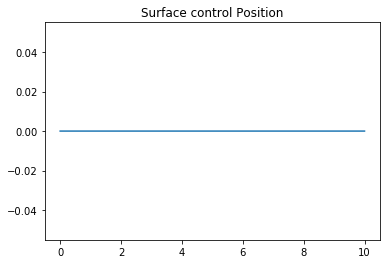

In [72]:
env = FooEnv(6,5,100) #loads the simulator with the wanted parameters

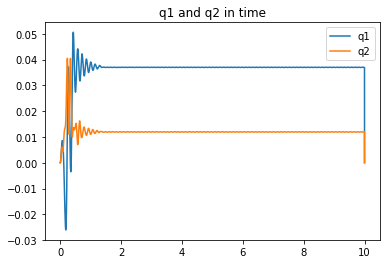

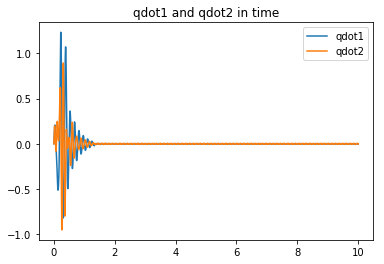

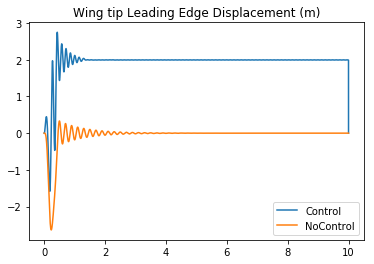

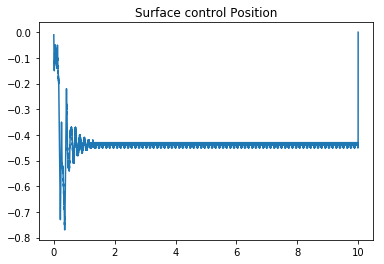

Score: [5778.00361441]


In [73]:
play_render() #play and plots the result in this notebook

In [74]:
#Prints the values for the criteria used in this work to evaluate the AI agent performance.

print('Overshoot%',100*np.max(np.abs(env.Z))/np.max(np.abs(env.zref)))

margin = np.max(np.abs(env.Z))*.03
final = env.Z[-2]
t1 = np.nonzero( (env.Z < final - np.abs(margin) ) | ( env.Z > final + np.abs(margin) ) )[0][-2]
print('Time to stabilize', t1, 'ms' )

margin = np.max(np.abs(env.zref))*.03
final = env.zref[-2]
t2 = np.nonzero( (env.zref < final - np.abs(margin) ) | ( env.zref > final + np.abs(margin) ) )[0][-2]
print('No control time to stabilize',t2, 'ms' )

print('Relative time to stabilize',t1/t2*100,)


print('Delta Max%', 100*(np.max(env.Z)-np.min(env.Z)) / (np.max(env.zref)-np.min(env.zref))  )


Overshoot% 104.29123444518872
Time to stabilize 1026 ms
No control time to stabilize 1704 ms
Relative time to stabilize 60.2112676056338
Delta Max% 145.9982213214148


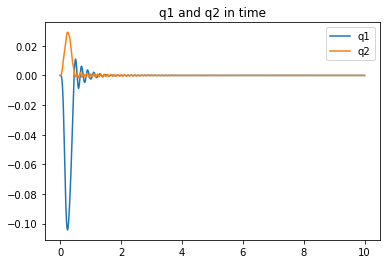

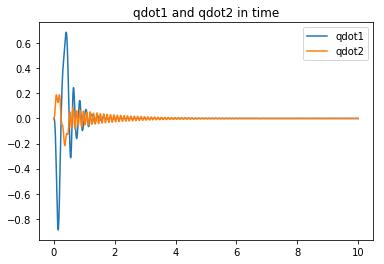

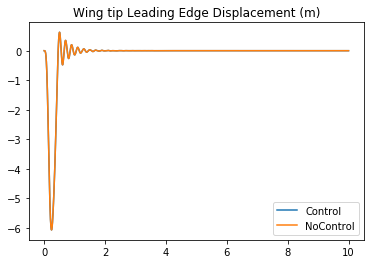

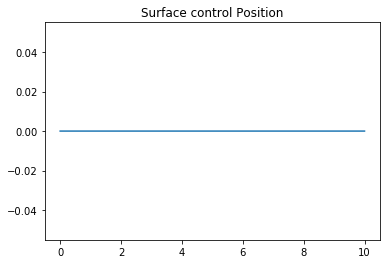

Score: [47787.02942277]


In [13]:
play_dumb() #plays without taking any action.

# Log Loading

In [69]:
import pandas as pd
logfile_path = filepath + '/' + 'log.txt'

Log = pd.read_csv(logfile_path)
Log.head()

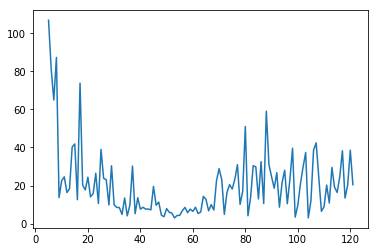

In [83]:
plt.plot(Log.Episode[5:])
plt.show()

# File saving tests

Play the tests that plots the result in a file.

In [ ]:
filename_play = filepath + '/' + 'Gameplay/' + DQN_SAVE + 'gameplay_'+ 'test_'
play_one(filename_play)

In [ ]:
filename_play = filepath + '/' + 'Test_vel/' 
if not os.path.exists(filename_play):
    os.makedirs(filename_play)
filename_test = filepath + '/' + 'Test_vel/' + DQN_SAVE + 'Vel_'

env = FooEnv(6,1)
for i in range(10):
    play_vel(filename_test)